# Get started!

In [1]:
from pathlib import Path
import polars as pl
import pandas as pd
from ebrec.utils._constants import *
from ebrec.utils._python import compute_npratio, create_lookup_dict

In [2]:
!pip install matplotlib seaborn
!pip install pyarrow
!pip install xlsx2csv

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mticker
from matplotlib.ticker import MaxNLocator

## Help functions

In [109]:
EB_COLOR = "#bd1118"


def save_figure(fig, save_path: str = None) -> None:
    if save_path is not None:
        path = Path(save_path)
        path.parent.mkdir(parents=True, exist_ok=True)
        fig.savefig(path, dpi=300)


def plot_histogram(
    df: pl.DataFrame,
    df_2: pl.DataFrame = None,
    column_name: str = None,
    stat: str = "density",
    save_path: str = None,
    x_max: int = None,
    y_max: int = None,
    binwidth: int = None,
    num_xticks: int = None,
    num_yticks: int = None,
    fontsize: int = 12,
    bins: int = "auto",
) -> None:
    # =>
    fig, ax = plt.subplots(figsize=(18, 14))
    sns.set_theme(style="whitegrid", font_scale=fontsize / 12)
    sns.histplot(
        data=df,
        x=column_name,
        color=EB_COLOR,
        binwidth=binwidth,
        alpha=0.5,
        stat=stat,
        bins=bins,
    )
    if x_max is not None:
        ax.set_xlim([0, x_max])
    if y_max is not None:
        ax.set_ylim([0, y_max])
    ax.yaxis.set_major_formatter(mticker.ScalarFormatter(useMathText=True))
    ax.xaxis.set_major_locator(MaxNLocator(integer=True, nbins=num_xticks))
    if num_yticks is not None:
        ax.yaxis.set_major_locator(MaxNLocator(nbins=num_yticks, prune="lower"))

    plt.grid(axis="x")
    plt.title("")
    plt.xlabel("")
    plt.ylabel(stat.capitalize())
    plt.ticklabel_format(style="sci", axis="y", scilimits=(0, 0))

    save_figure(fig, save_path=save_path)
    plt.show()


def create_bar_plot(
    df: pd.DataFrame,
    x_col: str,
    y_col: str,
    xlabel: str = "",
    ylabel: str = "",
    title: str = None,
    rotation: int = 0,
    fontsize: int = 12,
    colors: list[str] = None,
    y_as_percentage: bool = False,
    y_max: float = None,
    save_path: str = None,
):
    # Set style
    sns.set_theme(style="whitegrid", font_scale=fontsize / 12)
    # Create bar plot
    fig, ax = plt.subplots(figsize=(18, 14))
    ax = sns.barplot(
        data=df,
        x=x_col,
        y=y_col,
        alpha=0.80,
        palette=colors,
        legend=False,
        hue=x_col,
    )
    if y_as_percentage:
        # Format y-axis labels as percentage
        ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x:.0%}"))
    if y_max is not None:
        ax.set_ylim([0, y_max])
    if title:
        plt.title(title)

    # Set labels and title
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(rotation=rotation)

    # Remove top and right borders
    # sns.despine()
    plt.tight_layout()
    save_figure(fig, save_path=save_path)
    plt.show()


def create_plot(
    x,
    xlabel: str = "",
    ylabel: str = "",
    title: str = None,
    rotation: int = 0,
    marker: str = "",
    linestyle: str = "-",
    fontsize: int = 12,
    markersize: float = 2.0,
    linewidth: float = 2.0,
    color: str = None,
    y_as_percentage: bool = False,
    y_max: float = None,
    x_max: float = None,
    num_xticks: int = None,
    num_yticks: int = None,
    save_path: str = None,
):
    fig, ax = plt.subplots(figsize=(18, 14))
    plt.plot(
        x,
        linewidth=linewidth,
        color=color,
        marker=marker,
        markersize=markersize,
        linestyle=linestyle,
    )
    if y_as_percentage:
        ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x:.0%}"))
    else:
        ax.yaxis.set_major_formatter(mticker.ScalarFormatter(useMathText=True))
    if y_max is not None:
        ax.set_ylim([0, y_max])
    if x_max is not None:
        ax.set_xlim([0, x_max])
    if title:
        ax.set_title(title, fontsize=fontsize)

    ax.xaxis.set_major_locator(MaxNLocator(integer=True, nbins=num_xticks))
    if num_yticks is not None:
        ax.yaxis.set_major_locator(MaxNLocator(nbins=num_yticks, prune="lower"))

    ax.set_xlabel(xlabel, fontsize=fontsize)
    ax.set_ylabel(ylabel, fontsize=fontsize)
    ax.tick_params(axis="x", labelsize=fontsize)
    ax.tick_params(axis="y", labelsize=fontsize)
    plt.xticks(rotation=rotation)
    plt.tight_layout()
    save_figure(fig, save_path=save_path)
    plt.show()


def add_word_count_column(
    df: pl.DataFrame, column: str, column_alias: str
) -> pl.DataFrame:
    return df.with_columns(
        pl.when(pl.col(column) != "")
        .then(pl.col(column).str.split(by=" ").list.lengths())
        .otherwise(0)
        .alias(column_alias)
    )

----
# Load dataset

In [5]:
PATH = Path("~/ebnerd_data")
TRAIN_VAL_SPLIT = f"ebnerd_demo"  # [ebnerd_demo, ebnerd_small, ebnerd_large]
TEST_SPLIT = f"ebnerd_testset"

df_behaviors_train = df_behaviors = pl.scan_parquet(
    PATH.joinpath(TRAIN_VAL_SPLIT, "train", "behaviors.parquet")
)
df_history_train = df_behaviors = pl.scan_parquet(
    PATH.joinpath(TRAIN_VAL_SPLIT, "train", "history.parquet")
)
df_behaviors_val = df_behaviors = pl.scan_parquet(
    PATH.joinpath(TRAIN_VAL_SPLIT, "validation", "behaviors.parquet")
)
df_history_val = df_behaviors = pl.scan_parquet(
    PATH.joinpath(TRAIN_VAL_SPLIT, "validation", "history.parquet")
)
df_behaviors_test = df_behaviors = pl.scan_parquet(
    PATH.joinpath(TEST_SPLIT, "test", "behaviors.parquet")
)
df_history_test = df_behaviors = pl.scan_parquet(
    PATH.joinpath(TEST_SPLIT, "test", "history.parquet")
)
df_articles = pl.scan_parquet(PATH.joinpath(TEST_SPLIT, "articles.parquet")).collect()


PLOT_PATH = Path("plot")

## Define some help names

In [6]:
N_INVIEW_ARTICLES = "inview_len"
N_WORDS_TITLE = "title_len"
N_WORDS_SUBTITLE = "subtitle_len"
N_WORDS_BODY = "body_len"
CATEGORY_DIST_NAME = "category_distribution"

## Define helper columns

In [7]:
if DEFAULT_CLICKED_ARTICLES_COL in df_behaviors_test.columns:
    df_behaviors = pl.concat([df_behaviors_train, df_behaviors_val, df_behaviors_test])
else:
    df_behaviors = pl.concat([df_behaviors_train, df_behaviors_val])

df_history = pl.concat([df_history_train, df_history_val, df_history_test])

In [8]:
df_behaviors = df_behaviors.with_columns(
    pl.col(DEFAULT_INVIEW_ARTICLES_COL).list.lengths().alias(N_INVIEW_ARTICLES)
)
df_articles = (
    df_articles.pipe(add_word_count_column, column="title", column_alias=N_WORDS_TITLE)
    .pipe(add_word_count_column, column="subtitle", column_alias=N_WORDS_SUBTITLE)
    .pipe(add_word_count_column, column="body", column_alias=N_WORDS_BODY)
)

/var/folders/2l/k442jfhs2fd_3t2f7snmr_4w0000gq/T/ipykernel_69455/2383045193.py:2: DeprecationWarning: `lengths` is deprecated. It has been renamed to `len`.
  pl.col(DEFAULT_INVIEW_ARTICLES_COL).list.lengths().alias(N_INVIEW_ARTICLES)
/var/folders/2l/k442jfhs2fd_3t2f7snmr_4w0000gq/T/ipykernel_69455/3165121043.py:160: DeprecationWarning: `lengths` is deprecated. It has been renamed to `len`.
  .then(pl.col(column).str.split(by=" ").list.lengths())


# Dataset overview:

## Behaviors:

In [9]:
n_impressions = df_behaviors.select(DEFAULT_USER_COL).collect().shape[0]
print(f"Selected columns: {df_behaviors.columns}")
print(f"n-impressions: {n_impressions}")
df_behaviors_train.head(5).collect()

Selected columns: ['impression_id', 'article_id', 'impression_time', 'read_time', 'scroll_percentage', 'device_type', 'article_ids_inview', 'article_ids_clicked', 'user_id', 'is_sso_user', 'gender', 'postcode', 'age', 'is_subscriber', 'session_id', 'next_read_time', 'next_scroll_percentage', 'inview_len']
n-impressions: 50080


shape: (5, 17)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ impressio ‚îÜ article_i ‚îÜ impressio ‚îÜ read_time ‚îÜ ‚Ä¶ ‚îÜ is_subscr ‚îÜ session_i ‚îÜ next_read ‚îÜ next_scr ‚îÇ
‚îÇ n_id      ‚îÜ d         ‚îÜ n_time    ‚îÜ ---       ‚îÜ   ‚îÜ iber      ‚îÜ d         ‚îÜ _time     ‚îÜ oll_perc ‚îÇ
‚îÇ ---       ‚îÜ ---       ‚îÜ ---       ‚îÜ f32       ‚îÜ   ‚îÜ ---       ‚îÜ ---       ‚îÜ ---       ‚îÜ entage   ‚îÇ
‚îÇ u32       ‚îÜ i32       ‚îÜ datetime[ ‚îÜ           ‚îÜ   ‚îÜ bool      ‚îÜ u32       ‚îÜ f32       ‚îÜ ---      ‚îÇ
‚îÇ           ‚îÜ           ‚îÜ Œºs]       ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ f32      ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ 48401     ‚îÜ null      ‚îÜ 2023-05-2 ‚îÜ 21.0      ‚îÜ ‚Ä¶ ‚îÜ false     ‚îÜ 21        ‚îÜ 16.0      ‚îÜ 27.0     ‚îÇ
‚îÇ           ‚îÜ           ‚îÜ 1         ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ          ‚îÇ
‚îÇ           ‚îÜ           ‚îÜ 21:06:50  ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ          ‚îÇ
‚îÇ 152513    ‚îÜ 9778745   ‚îÜ 2023-05-2 ‚îÜ 30.0      ‚îÜ ‚Ä¶ ‚îÜ false     ‚îÜ 298       ‚îÜ 2.0       ‚îÜ 48.0     ‚îÇ
‚îÇ           ‚îÜ           ‚îÜ 4         ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ          ‚îÇ
‚îÇ           ‚îÜ           ‚îÜ 07:31:26  ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ          ‚îÇ
‚îÇ 155390    ‚îÜ null      ‚îÜ 2023-05-2 ‚îÜ 45.0      ‚îÜ ‚Ä¶ ‚îÜ false     ‚îÜ 401       ‚îÜ 215.0     ‚îÜ 100.0    ‚îÇ
‚îÇ           ‚îÜ           ‚îÜ 4         ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ          ‚îÇ
‚îÇ           ‚îÜ           ‚îÜ 07:30:33  ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ          ‚îÇ
‚îÇ 214679    ‚îÜ null      ‚îÜ 2023-05-2 ‚îÜ 33.0      ‚îÜ ‚Ä¶ ‚îÜ false     ‚îÜ 1357      ‚îÜ 40.0      ‚îÜ 47.0     ‚îÇ
‚îÇ           ‚îÜ           ‚îÜ 3         ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ          ‚îÇ
‚îÇ           ‚îÜ           ‚îÜ 05:25:40  ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ          ‚îÇ
‚îÇ 214681    ‚îÜ null      ‚îÜ 2023-05-2 ‚îÜ 21.0      ‚îÜ ‚Ä¶ ‚îÜ false     ‚îÜ 1358      ‚îÜ 5.0       ‚îÜ 49.0     ‚îÇ
‚îÇ           ‚îÜ           ‚îÜ 3         ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ          ‚îÇ
‚îÇ           ‚îÜ           ‚îÜ 05:31:54  ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ          ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

## Articles:

In [10]:
print(f"Shape: {df_articles.select(DEFAULT_ARTICLE_ID_COL).shape}")
print(df_articles.columns)
df_articles.head(5)

Shape: (125541, 1)
['article_id', 'title', 'subtitle', 'last_modified_time', 'premium', 'body', 'published_time', 'image_ids', 'article_type', 'url', 'ner_clusters', 'entity_groups', 'topics', 'category', 'subcategory', 'category_str', 'total_inviews', 'total_pageviews', 'total_read_time', 'sentiment_score', 'sentiment_label', 'title_len', 'subtitle_len', 'body_len']


shape: (5, 24)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ article_i ‚îÜ title     ‚îÜ subtitle  ‚îÜ last_modi ‚îÜ ‚Ä¶ ‚îÜ sentiment ‚îÜ title_len ‚îÜ subtitle_ ‚îÜ body_len ‚îÇ
‚îÇ d         ‚îÜ ---       ‚îÜ ---       ‚îÜ fied_time ‚îÜ   ‚îÜ _label    ‚îÜ ---       ‚îÜ len       ‚îÜ ---      ‚îÇ
‚îÇ ---       ‚îÜ str       ‚îÜ str       ‚îÜ ---       ‚îÜ   ‚îÜ ---       ‚îÜ u32       ‚îÜ ---       ‚îÜ u32      ‚îÇ
‚îÇ i32       ‚îÜ           ‚îÜ           ‚îÜ datetime[ ‚îÜ   ‚îÜ str       ‚îÜ           ‚îÜ u32       ‚îÜ          ‚îÇ
‚îÇ           ‚îÜ           ‚îÜ           ‚îÜ Œºs]       ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ          ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ 3000022   ‚îÜ Hanks     ‚îÜ Tom Hanks ‚îÜ 2023-06-2 ‚îÜ ‚Ä¶ ‚îÜ Negative  ‚îÜ 4         ‚îÜ 16        ‚îÜ 119      ‚îÇ
‚îÇ           ‚îÜ beskyldt  ‚îÜ har angiv ‚îÜ 9         ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ          ‚îÇ
‚îÇ           ‚îÜ for misha ‚îÜ eligt     ‚îÜ 06:20:32  ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ          ‚îÇ
‚îÇ           ‚îÜ ndling    ‚îÜ mishand‚Ä¶  ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ          ‚îÇ
‚îÇ 3000063   ‚îÜ Bostrups  ‚îÜ Studiev√¶r ‚îÜ 2023-06-2 ‚îÜ ‚Ä¶ ‚îÜ Neutral   ‚îÜ 5         ‚îÜ 6         ‚îÜ 388      ‚îÇ
‚îÇ           ‚îÜ aske      ‚îÜ ten blev  ‚îÜ 9         ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ          ‚îÇ
‚îÇ           ‚îÜ spredt i  ‚îÜ mindet    ‚îÜ 06:20:32  ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ          ‚îÇ
‚îÇ           ‚îÜ Fures√∏en  ‚îÜ med gla‚Ä¶  ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ          ‚îÇ
‚îÇ 3000613   ‚îÜ Jesper    ‚îÜ Den       ‚îÜ 2023-06-2 ‚îÜ ‚Ä¶ ‚îÜ Negative  ‚îÜ 5         ‚îÜ 16        ‚îÜ 136      ‚îÇ
‚îÇ           ‚îÜ Olsen     ‚îÜ tidligere ‚îÜ 9         ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ          ‚îÇ
‚îÇ           ‚îÜ ramt af   ‚îÜ danske    ‚îÜ 06:20:33  ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ          ‚îÇ
‚îÇ           ‚îÜ hjernebl√∏ ‚îÜ landshold ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ          ‚îÇ
‚îÇ           ‚îÜ dn‚Ä¶       ‚îÜ ss‚Ä¶       ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ          ‚îÇ
‚îÇ 3000700   ‚îÜ Madonna   ‚îÜ 47-√•rige  ‚îÜ 2023-06-2 ‚îÜ ‚Ä¶ ‚îÜ Neutral   ‚îÜ 4         ‚îÜ 26        ‚îÜ 150      ‚îÇ
‚îÇ           ‚îÜ topl√∏s    ‚îÜ Madonna   ‚îÜ 9         ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ          ‚îÇ
‚îÇ           ‚îÜ med heste ‚îÜ poserer   ‚îÜ 06:20:33  ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ          ‚îÇ
‚îÇ           ‚îÜ           ‚îÜ b√•de to‚Ä¶  ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ          ‚îÇ
‚îÇ 3000840   ‚îÜ Otto Bran ‚îÜ Sangeren  ‚îÜ 2023-06-2 ‚îÜ ‚Ä¶ ‚îÜ Negative  ‚îÜ 4         ‚îÜ 13        ‚îÜ 142      ‚îÇ
‚îÇ           ‚îÜ denburg   ‚îÜ og skuesp ‚îÜ 9         ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ          ‚îÇ
‚îÇ           ‚îÜ er d√∏d    ‚îÜ illeren   ‚îÜ 06:20:33  ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ          ‚îÇ
‚îÇ           ‚îÜ           ‚îÜ Otto B‚Ä¶   ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ          ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚

## More descriptive:

In [11]:
n_pos = (
    pl.concat([df_behaviors_train, df_behaviors_val])
    .select(pl.col(DEFAULT_CLICKED_ARTICLES_COL).list.len())
    .sum()
    .collect()
)[DEFAULT_CLICKED_ARTICLES_COL][0]
n_neg = (
    pl.concat([df_behaviors_train, df_behaviors_val])
    .select(
        pl.col(DEFAULT_INVIEW_ARTICLES_COL).list.len()
        - pl.col(DEFAULT_CLICKED_ARTICLES_COL).list.len()
    )
    .sum()
    .collect()
)[DEFAULT_INVIEW_ARTICLES_COL][0]

n_users = df_behaviors.select(DEFAULT_USER_COL).unique().collect().shape[0]
n_sso_users = (
    df_behaviors.select(pl.col(DEFAULT_IS_SSO_USER_COL))
    .sum()
    .collect()[DEFAULT_IS_SSO_USER_COL][0]
)
n_subscriber_users = (
    df_behaviors.select(pl.col(DEFAULT_IS_SUBSCRIBER_COL))
    .sum()
    .collect()[DEFAULT_IS_SUBSCRIBER_COL][0]
)
n_articles = df_articles.select(DEFAULT_ARTICLE_ID_COL).unique().shape[0]
n_categories = df_articles.select(DEFAULT_CATEGORY_COL).unique().shape[0]
n_subcategories = (
    df_articles.select(pl.col(DEFAULT_SUBCATEGORY_COL).explode()).unique().shape[0]
)
print(f"# Categories: {n_categories}")
print(f"# Subcategories: {n_subcategories}")


def avg_impression_per_user(n_impressions, n_users) -> float:
    return n_impressions / n_users


descriptive_dict = {
    f"# News": n_articles,
    f"# Users": n_users,
    f"# News category": n_categories,
    f"# Impressions": n_impressions,
    f"# News subcategory": n_subcategories,
    f"# Positive": n_pos,
    f"# Negative": n_neg,
    f"NP-ratio": round(compute_npratio(n_pos=n_pos, n_neg=n_neg), 2),
    f"Avg. impression per user": round(
        avg_impression_per_user(n_impressions=n_impressions, n_users=n_users), 2
    ),
    f"Avg. title len. (words)": round(
        df_articles.select(pl.col(N_WORDS_TITLE)).mean()[N_WORDS_TITLE][0], 2
    ),
    f"Avg. abstract len. (words)": round(
        df_articles.select(pl.col(N_WORDS_SUBTITLE)).mean()[N_WORDS_SUBTITLE][0],
        2,
    ),
    f"Avg. body len. (words)": round(
        df_articles.select(pl.col(N_WORDS_BODY)).mean()[N_WORDS_BODY][0],
        2,
    ),
    f"# SSO users": n_sso_users,
    f"# Subscriber users": n_subscriber_users,
}
_ = [print(f"{key}: {value}") for key, value in descriptive_dict.items()]

# Categories: 32
# Subcategories: 263
# News: 125541
# Users: 1935
# News category: 32
# Impressions: 50080
# News subcategory: 263
# Positive: 50393
# Negative: 532661
NP-ratio: 10.57
Avg. impression per user: 25.88
Avg. title len. (words): 6.6
Avg. abstract len. (words): 17.3
Avg. body len. (words): 363.23
# SSO users: 5321
# Subscriber users: 3229


-----
# Visualizations:

## Textual features in Articles:

### Title

shape: (9, 2)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ statistic  ‚îÜ value    ‚îÇ
‚îÇ ---        ‚îÜ ---      ‚îÇ
‚îÇ str        ‚îÜ f64      ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ count      ‚îÜ 125541.0 ‚îÇ
‚îÇ null_count ‚îÜ 0.0      ‚îÇ
‚îÇ mean       ‚îÜ 6.601636 ‚îÇ
‚îÇ std        ‚îÜ 2.496316 ‚îÇ
‚îÇ min        ‚îÜ 0.0      ‚îÇ
‚îÇ 25%        ‚îÜ 5.0      ‚îÇ
‚îÇ 50%        ‚îÜ 6.0      ‚îÇ
‚îÇ 75%        ‚îÜ 8.0      ‚îÇ
‚îÇ max        ‚îÜ 27.0     ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò


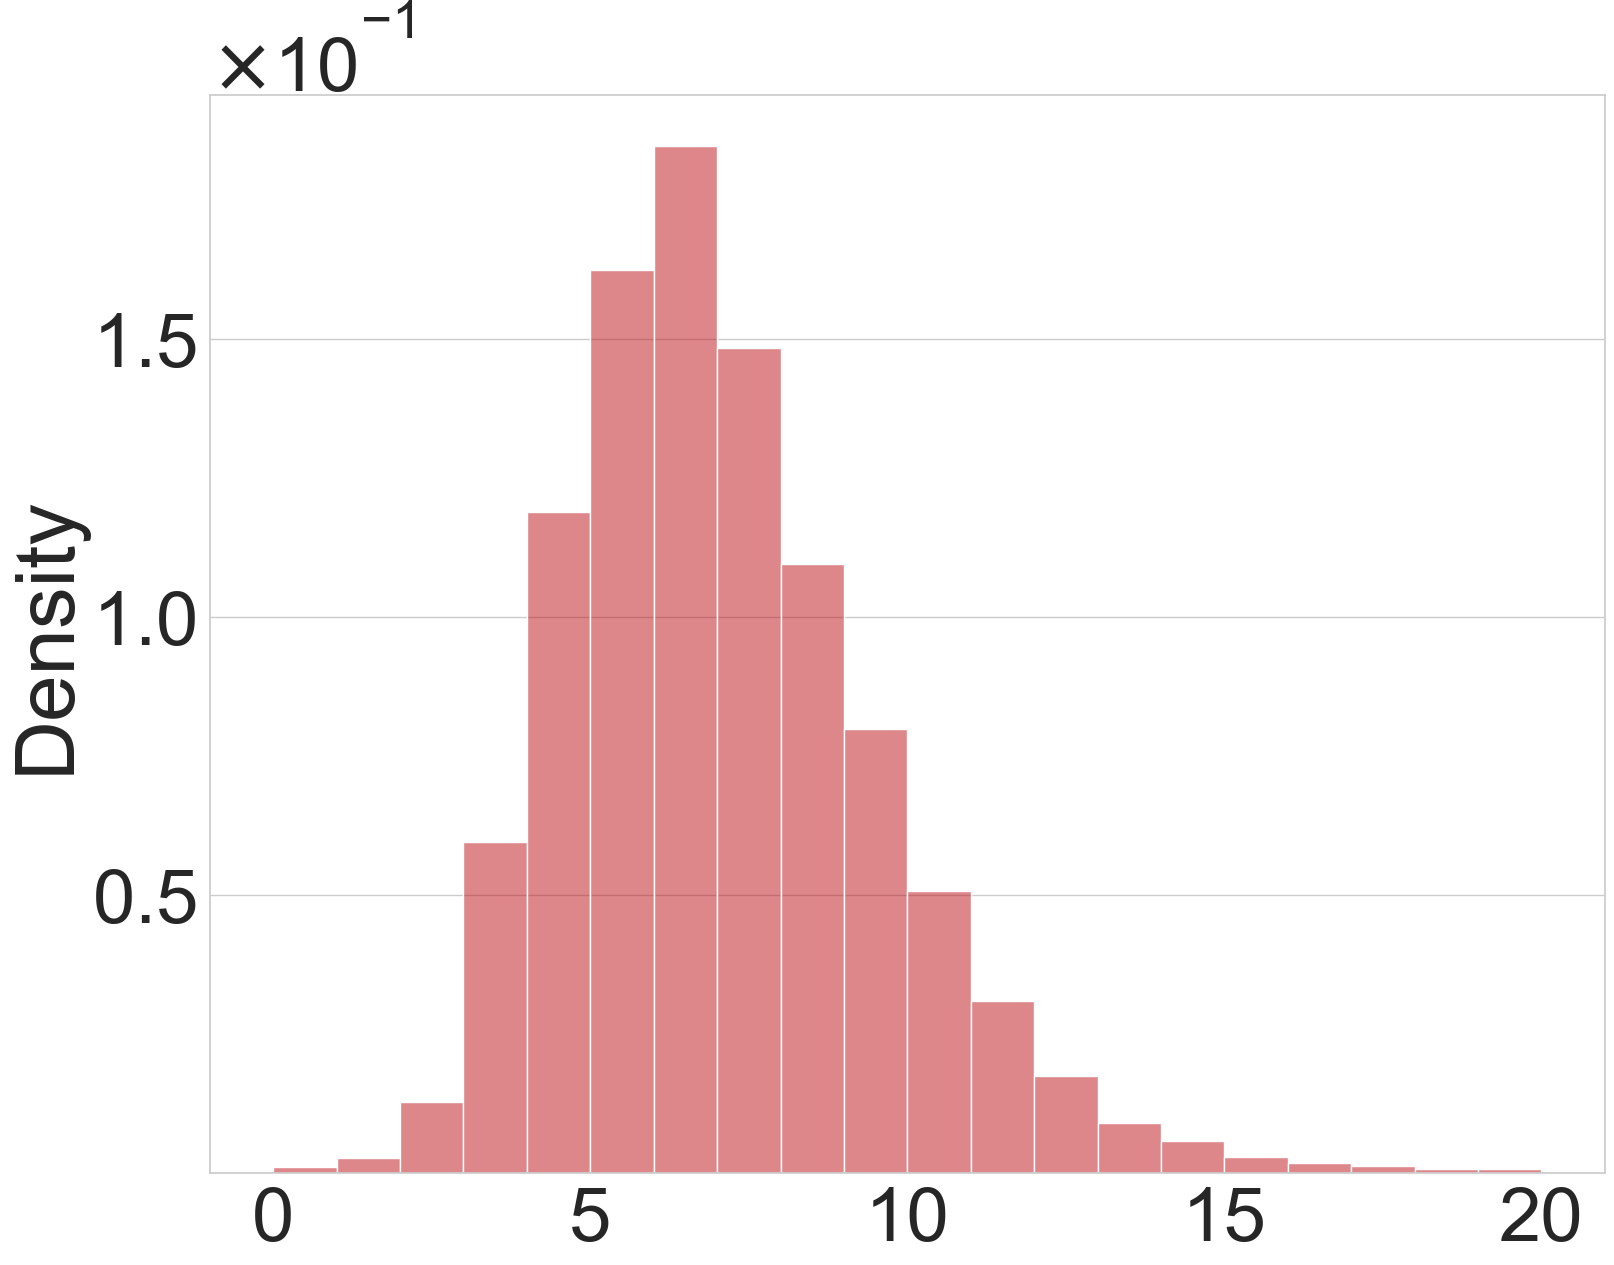

In [35]:
#
print(df_articles[N_WORDS_TITLE].describe())
plot_histogram(
    df_articles.filter(pl.col(N_WORDS_TITLE) <= 20).select(N_WORDS_TITLE),
    num_xticks=5,
    num_yticks=4,
    fontsize=60,
    binwidth=1,
    column_name=N_WORDS_TITLE,
    save_path=PLOT_PATH.joinpath(N_WORDS_TITLE + ".png"),
)

### Subtitle

shape: (9, 2)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ statistic  ‚îÜ value     ‚îÇ
‚îÇ ---        ‚îÜ ---       ‚îÇ
‚îÇ str        ‚îÜ f64       ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ count      ‚îÜ 125541.0  ‚îÇ
‚îÇ null_count ‚îÜ 0.0       ‚îÇ
‚îÇ mean       ‚îÜ 17.301607 ‚îÇ
‚îÇ std        ‚îÜ 8.643949  ‚îÇ
‚îÇ min        ‚îÜ 0.0       ‚îÇ
‚îÇ 25%        ‚îÜ 13.0      ‚îÇ
‚îÇ 50%        ‚îÜ 17.0      ‚îÇ
‚îÇ 75%        ‚îÜ 22.0      ‚îÇ
‚îÇ max        ‚îÜ 157.0     ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò


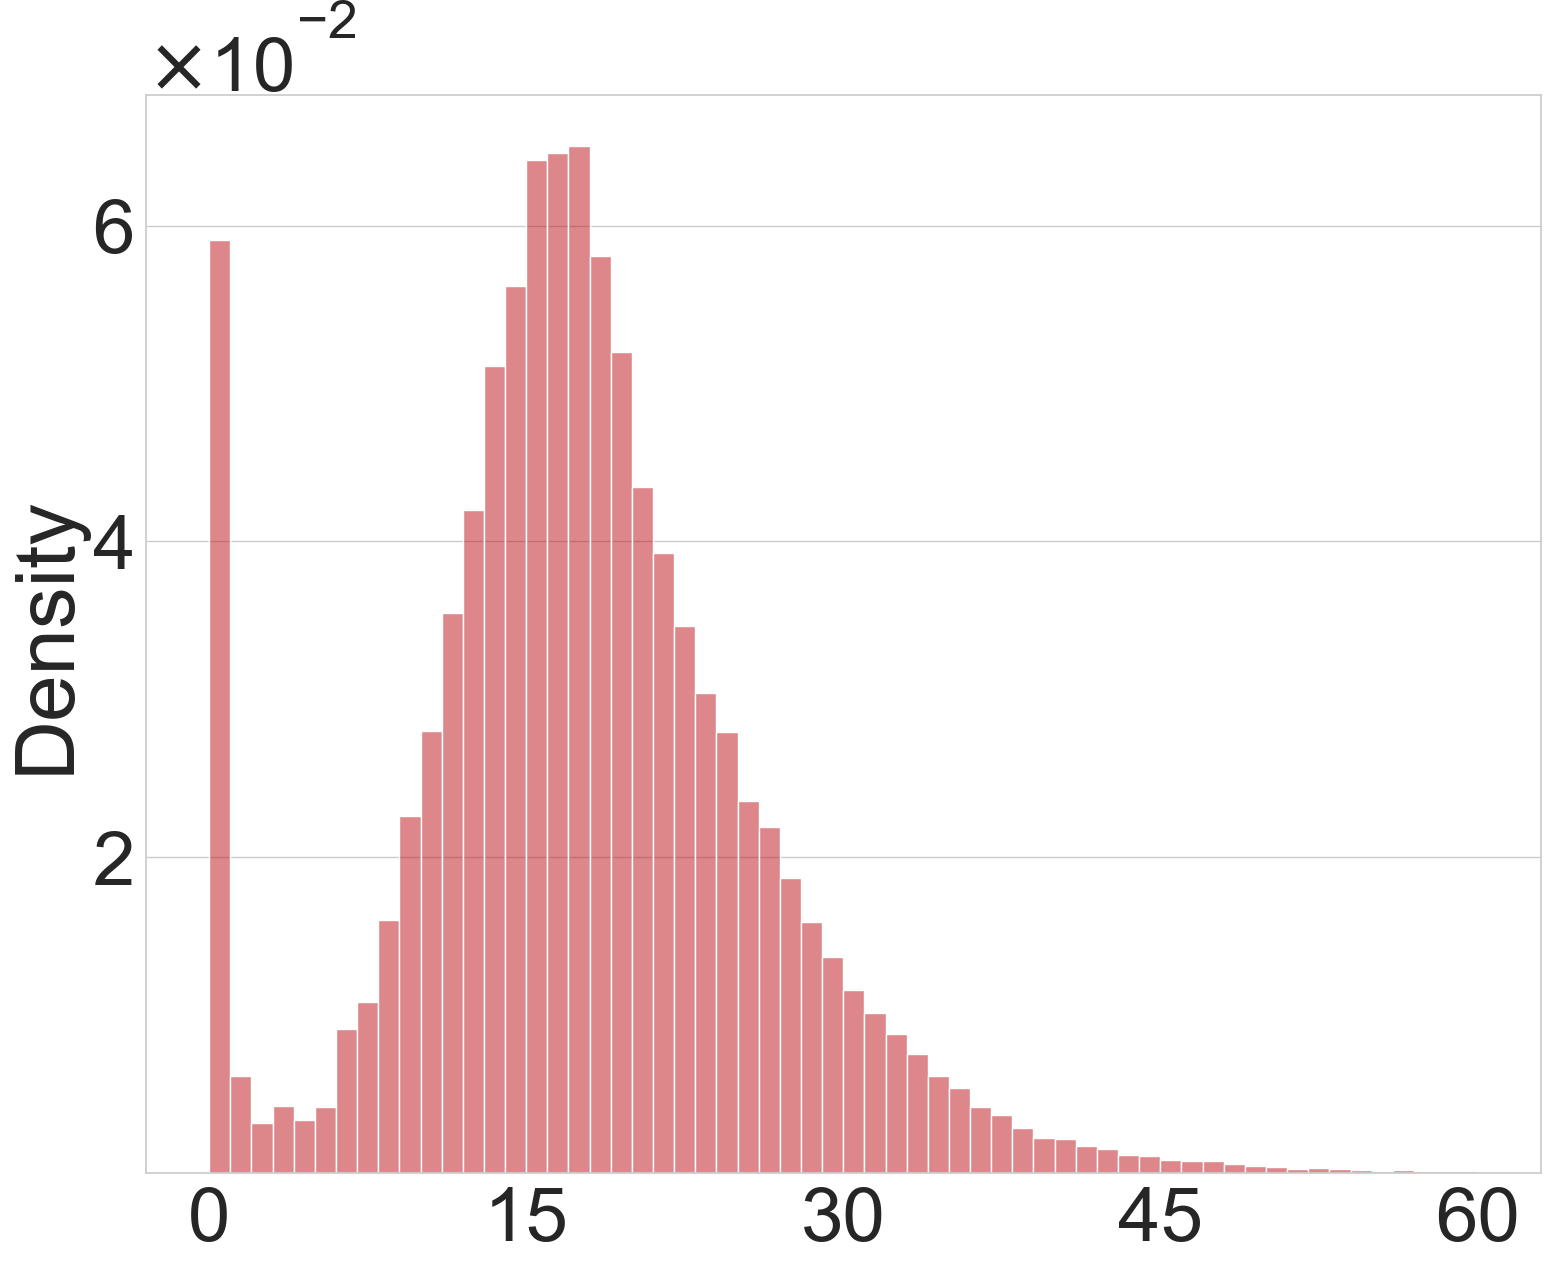

In [38]:
print(df_articles[N_WORDS_SUBTITLE].describe())
plot_histogram(
    df_articles.filter(pl.col(N_WORDS_SUBTITLE) <= 60).select(N_WORDS_SUBTITLE),
    num_xticks=6,
    num_yticks=4,
    fontsize=60,
    binwidth=1,
    column_name=N_WORDS_SUBTITLE,
    save_path=PLOT_PATH.joinpath(N_WORDS_SUBTITLE + ".png"),
)

### Body

shape: (9, 2)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ statistic  ‚îÜ value      ‚îÇ
‚îÇ ---        ‚îÜ ---        ‚îÇ
‚îÇ str        ‚îÜ f64        ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ count      ‚îÜ 125541.0   ‚îÇ
‚îÇ null_count ‚îÜ 0.0        ‚îÇ
‚îÇ mean       ‚îÜ 363.231175 ‚îÇ
‚îÇ std        ‚îÜ 306.16982  ‚îÇ
‚îÇ min        ‚îÜ 0.0        ‚îÇ
‚îÇ 25%        ‚îÜ 195.0      ‚îÇ
‚îÇ 50%        ‚îÜ 295.0      ‚îÇ
‚îÇ 75%        ‚îÜ 451.0      ‚îÇ
‚îÇ max        ‚îÜ 10482.0    ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò


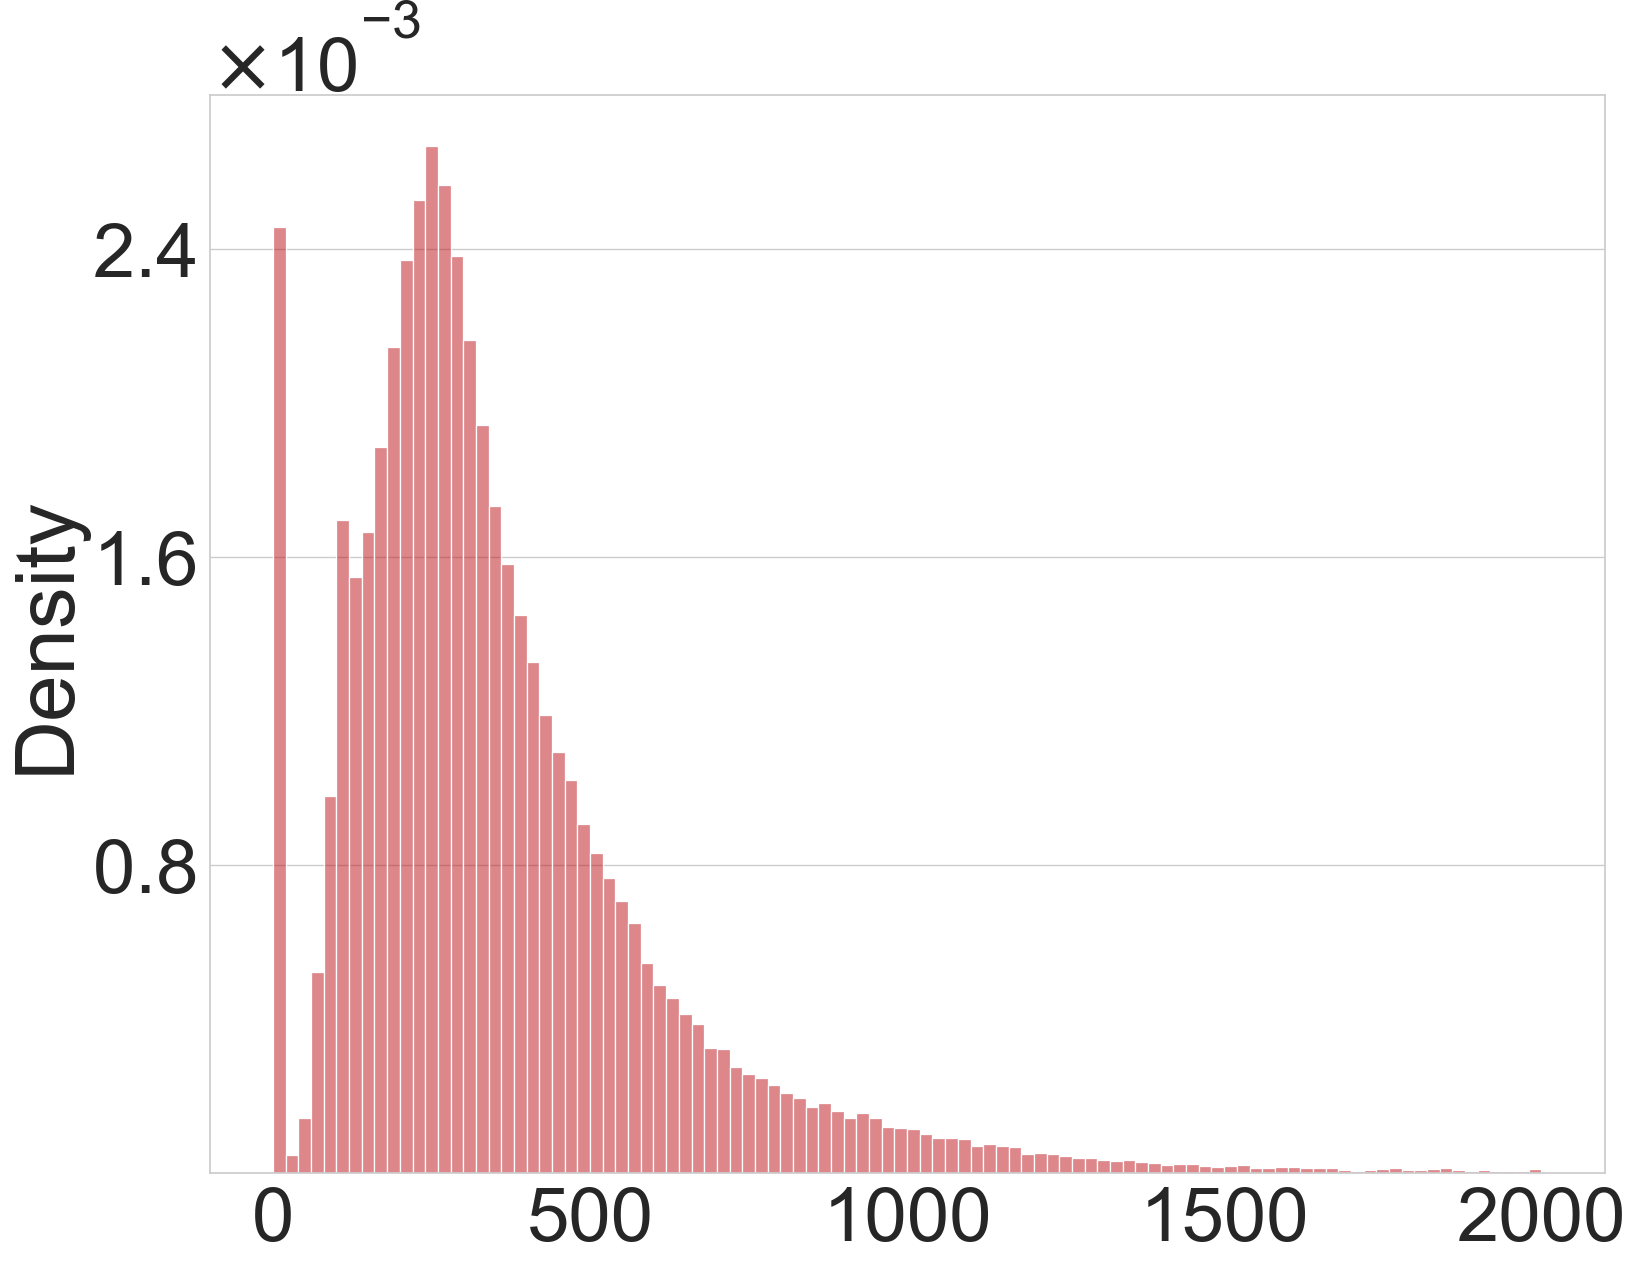

In [39]:
print(df_articles[N_WORDS_BODY].describe())
plot_histogram(
    df_articles.filter(pl.col(N_WORDS_BODY) <= 2_000).select(N_WORDS_BODY),
    num_xticks=5,
    num_yticks=4,
    fontsize=60,
    bins=100,
    binwidth=None,
    column_name=N_WORDS_BODY,
    save_path=PLOT_PATH.joinpath(N_WORDS_BODY + ".png"),
)

## Number of in-view articles per impression

shape: (9, 2)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ statistic  ‚îÜ inview_len ‚îÇ
‚îÇ ---        ‚îÜ ---        ‚îÇ
‚îÇ str        ‚îÜ f64        ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ count      ‚îÜ 50080.0    ‚îÇ
‚îÇ null_count ‚îÜ 0.0        ‚îÇ
‚îÇ mean       ‚îÜ 11.642452  ‚îÇ
‚îÇ std        ‚îÜ 8.667524   ‚îÇ
‚îÇ min        ‚îÜ 5.0        ‚îÇ
‚îÇ 25%        ‚îÜ 6.0        ‚îÇ
‚îÇ 50%        ‚îÜ 9.0        ‚îÇ
‚îÇ 75%        ‚îÜ 14.0       ‚îÇ
‚îÇ max        ‚îÜ 100.0      ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò


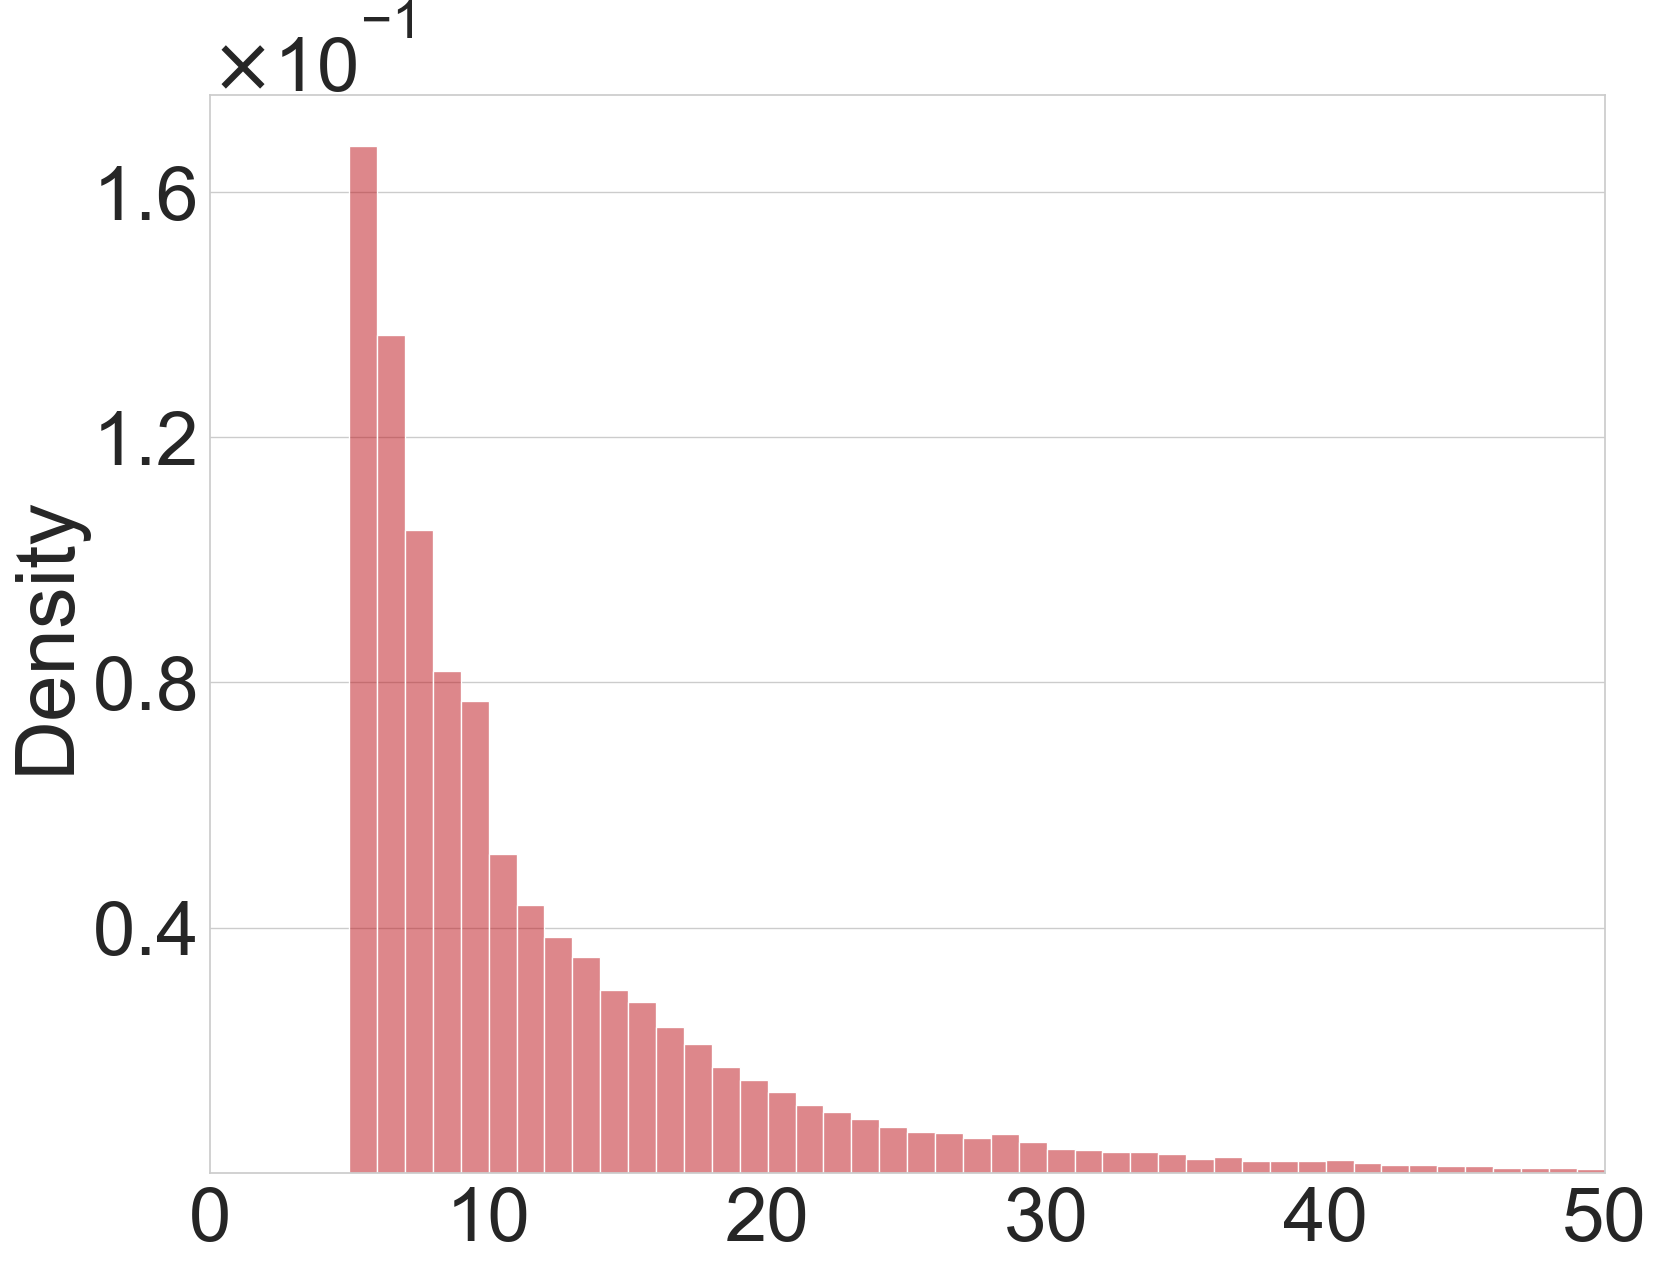

In [40]:
print(df_behaviors.select(N_INVIEW_ARTICLES).describe())
# =>
plot_histogram(
    df_behaviors.select(N_INVIEW_ARTICLES).collect(),
    x_max=50,
    num_xticks=5,
    num_yticks=5,
    fontsize=60,
    binwidth=1,
    column_name=N_INVIEW_ARTICLES,
    save_path=PLOT_PATH.joinpath(N_INVIEW_ARTICLES + f".png"),
)

## Front vs. Article page:

In [14]:
df_frontpage = df_behaviors.filter(pl.col(DEFAULT_ARTICLE_ID_COL).is_null()).collect()
df_articlepage = df_behaviors.filter(
    pl.col(DEFAULT_ARTICLE_ID_COL).is_not_null()
).collect()

### Inviews - front- vs. article page:

/var/folders/2l/k442jfhs2fd_3t2f7snmr_4w0000gq/T/ipykernel_69455/677349473.py:12: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


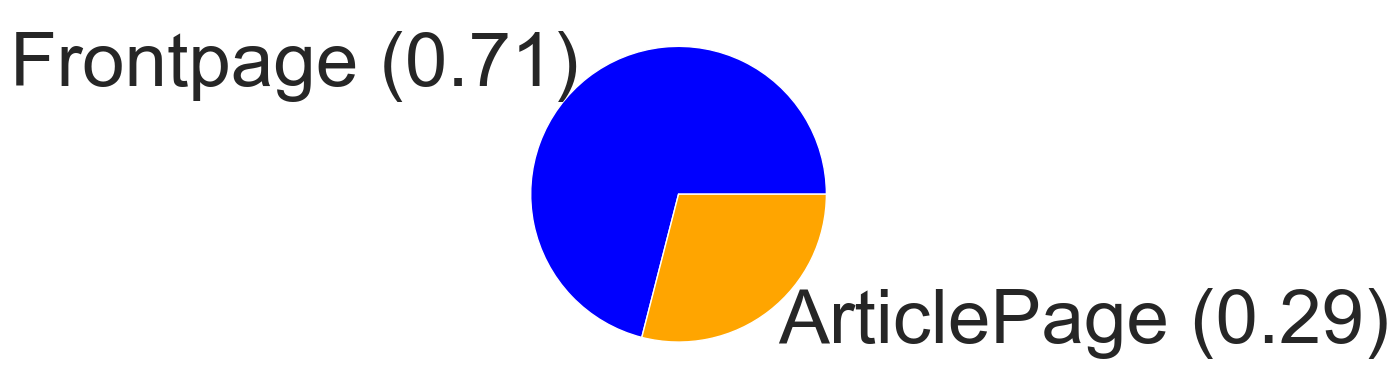

In [15]:
article_page_frac = round(
    df_articlepage.shape[0]
    / df_behaviors.select(DEFAULT_ARTICLE_ID_COL).collect().shape[0],
    2,
)
frontpage_frac = round(1 - article_page_frac, 2)
#
sizes = [frontpage_frac, article_page_frac]
labels = f"Frontpage ({frontpage_frac})", f"ArticlePage ({article_page_frac})"
fig, ax = plt.subplots()
front_article_page = ax.pie(sizes, labels=labels, colors=["blue", "orange"])
plt.tight_layout()
plt.show()
save_figure(fig, save_path=PLOT_PATH.joinpath("front_article_page.png"))

### Readtime - front- vs. article page:

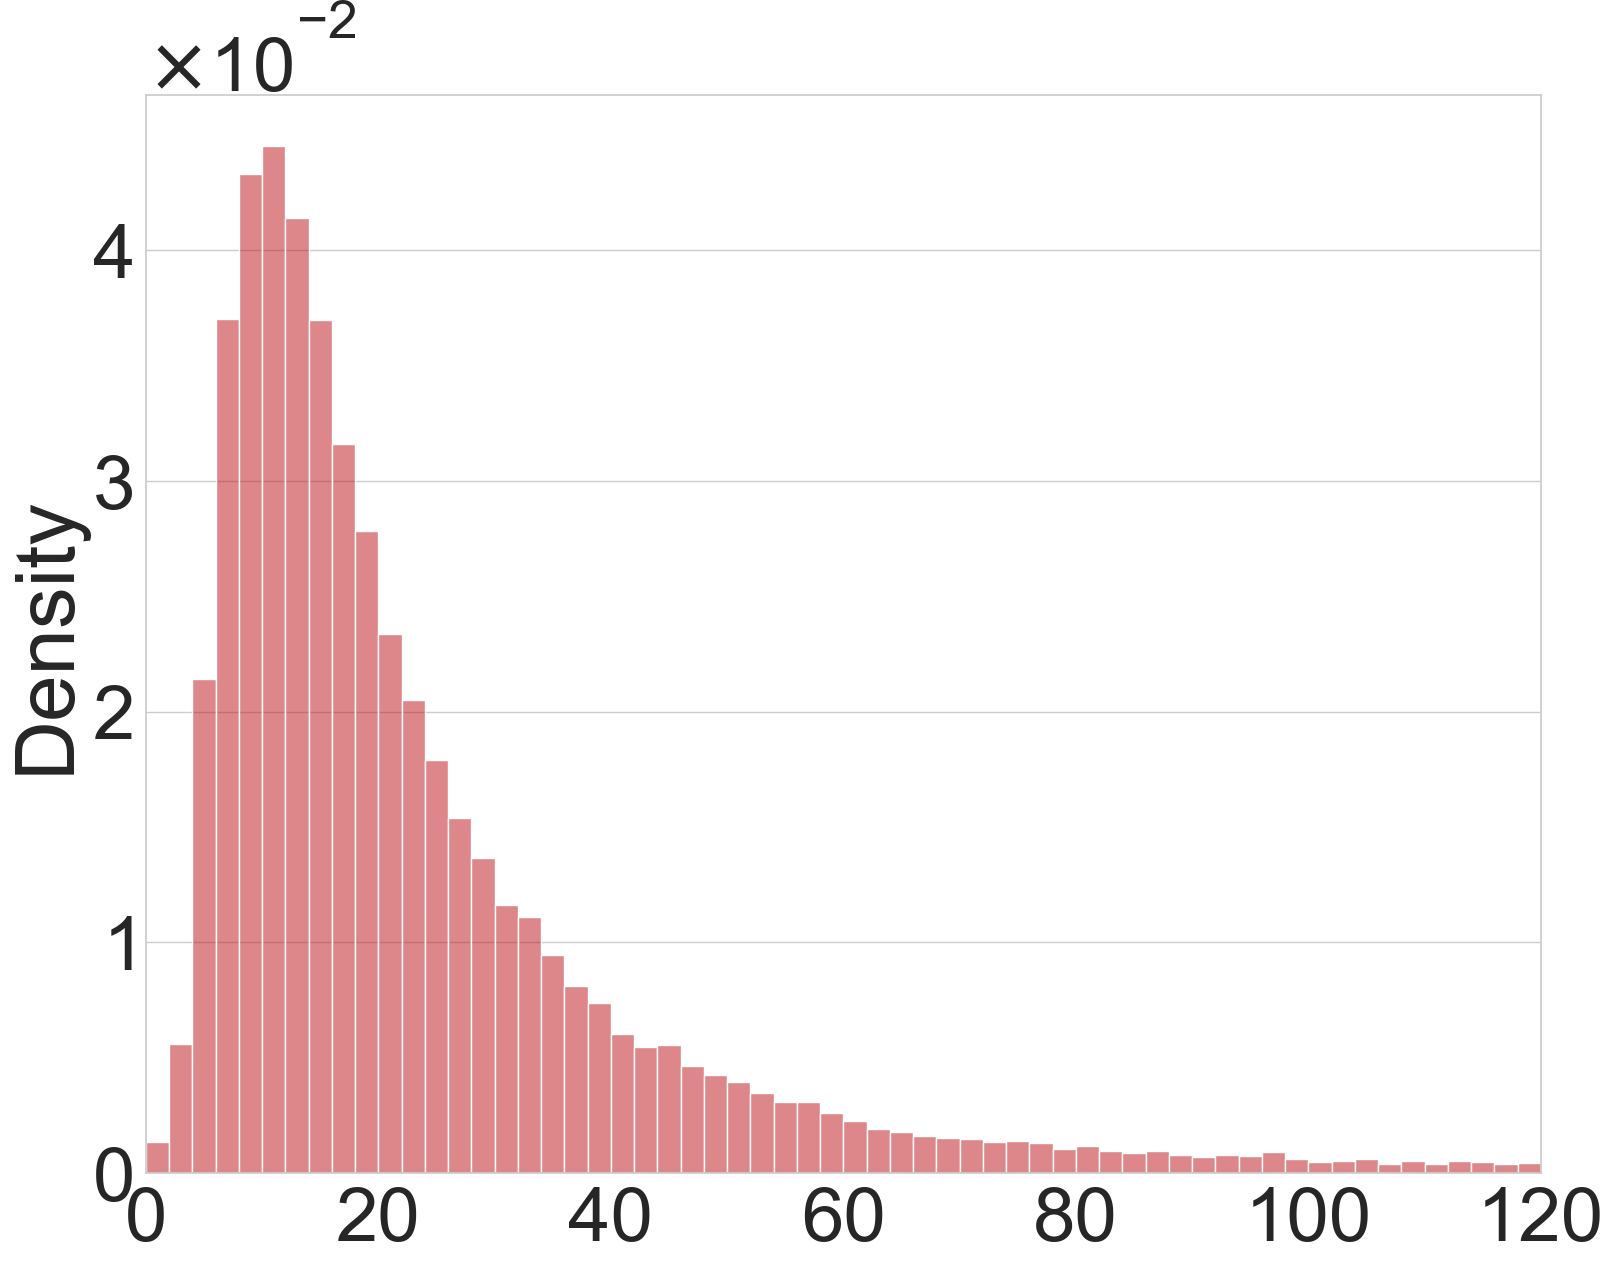

In [110]:
N_SHOW = 120
plot_histogram(
    df_frontpage.filter(pl.col(DEFAULT_READ_TIME_COL) <= N_SHOW).select(
        DEFAULT_READ_TIME_COL
    ),
    column_name=DEFAULT_READ_TIME_COL,
    x_max=N_SHOW,
    bins=60,
    num_xticks=6,
    fontsize=60,
    save_path=PLOT_PATH.joinpath("front_read_time.png"),
)

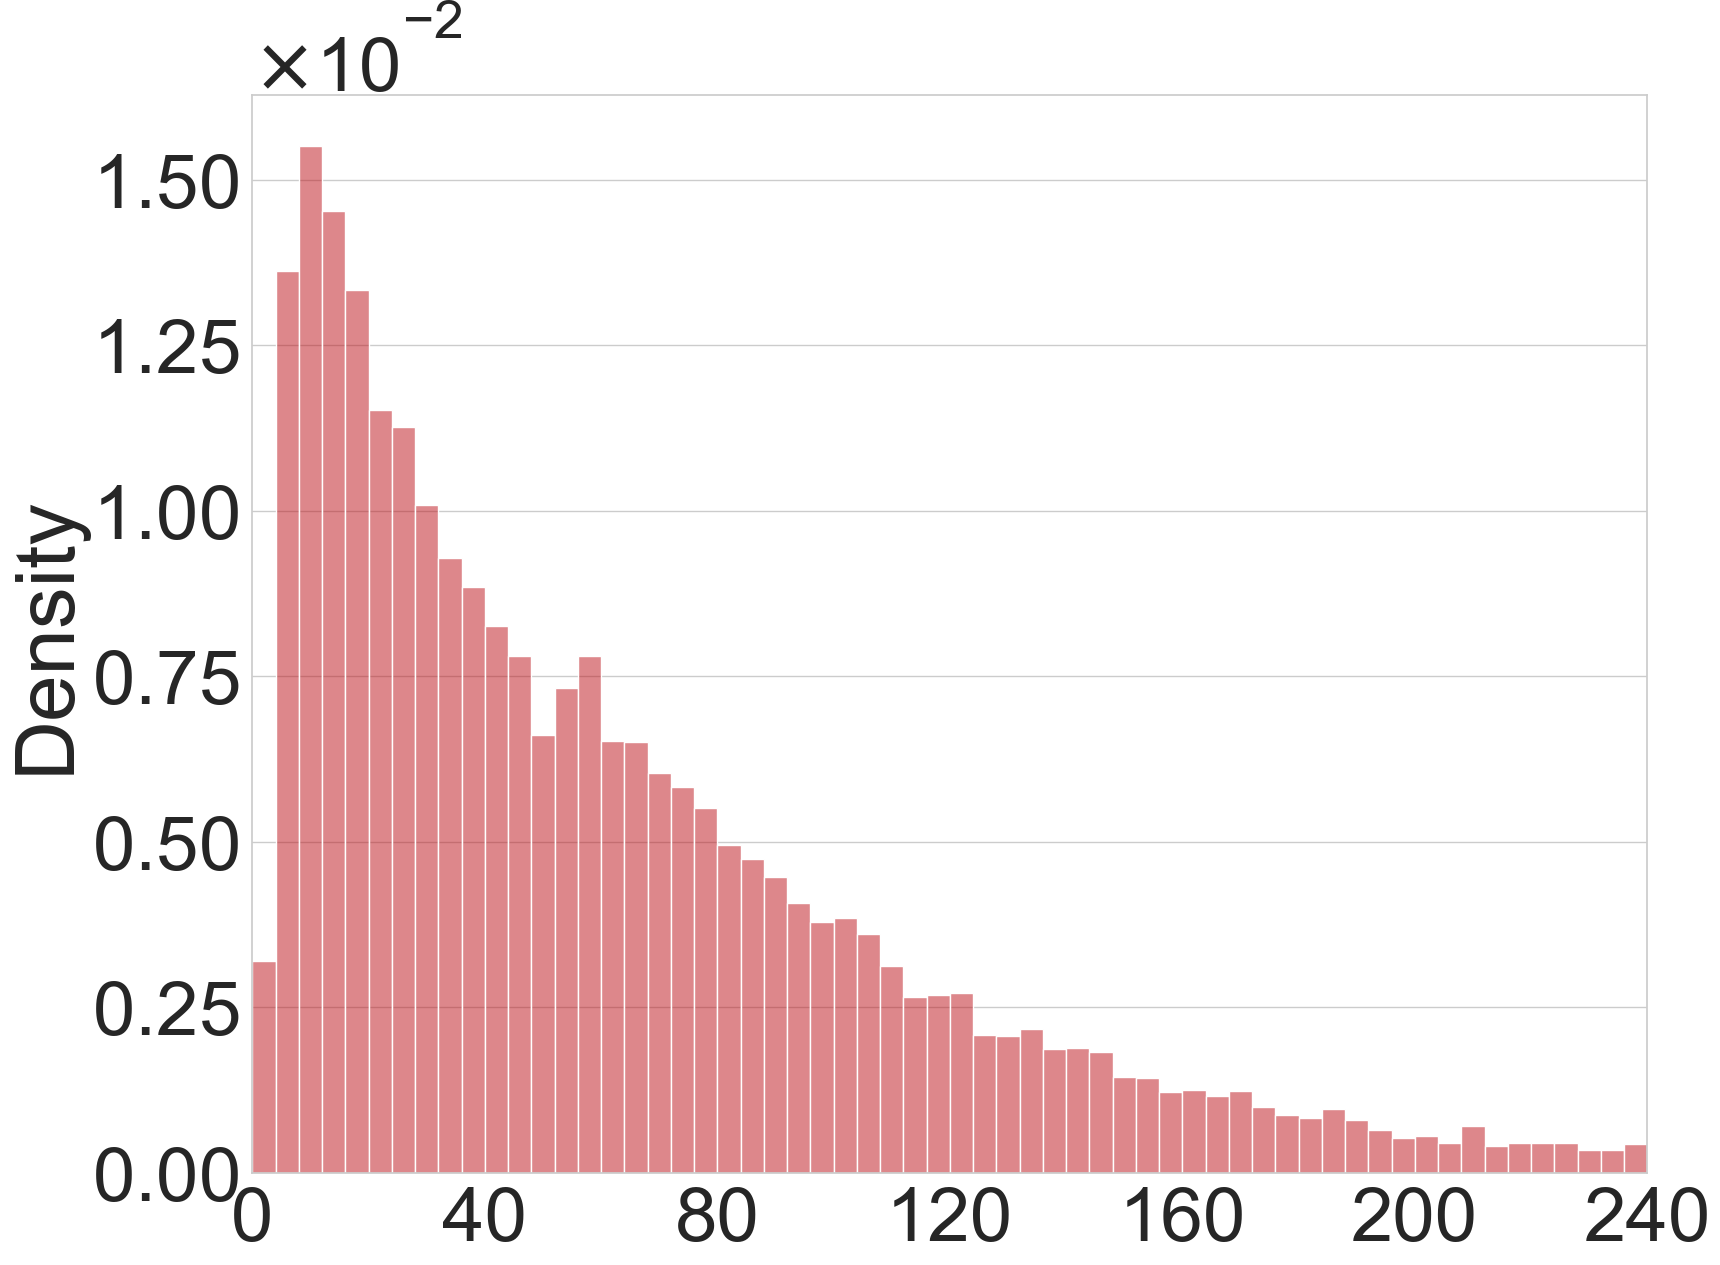

In [111]:
N_SHOW = 240
plot_histogram(
    df_articlepage.filter(pl.col(DEFAULT_READ_TIME_COL) <= N_SHOW).select(
        DEFAULT_READ_TIME_COL
    ),
    column_name=DEFAULT_READ_TIME_COL,
    x_max=N_SHOW,
    bins=60,
    num_xticks=6,
    fontsize=60,
    save_path=PLOT_PATH.joinpath("article_read_time.png"),
)

### Scroll percentage on article-page:

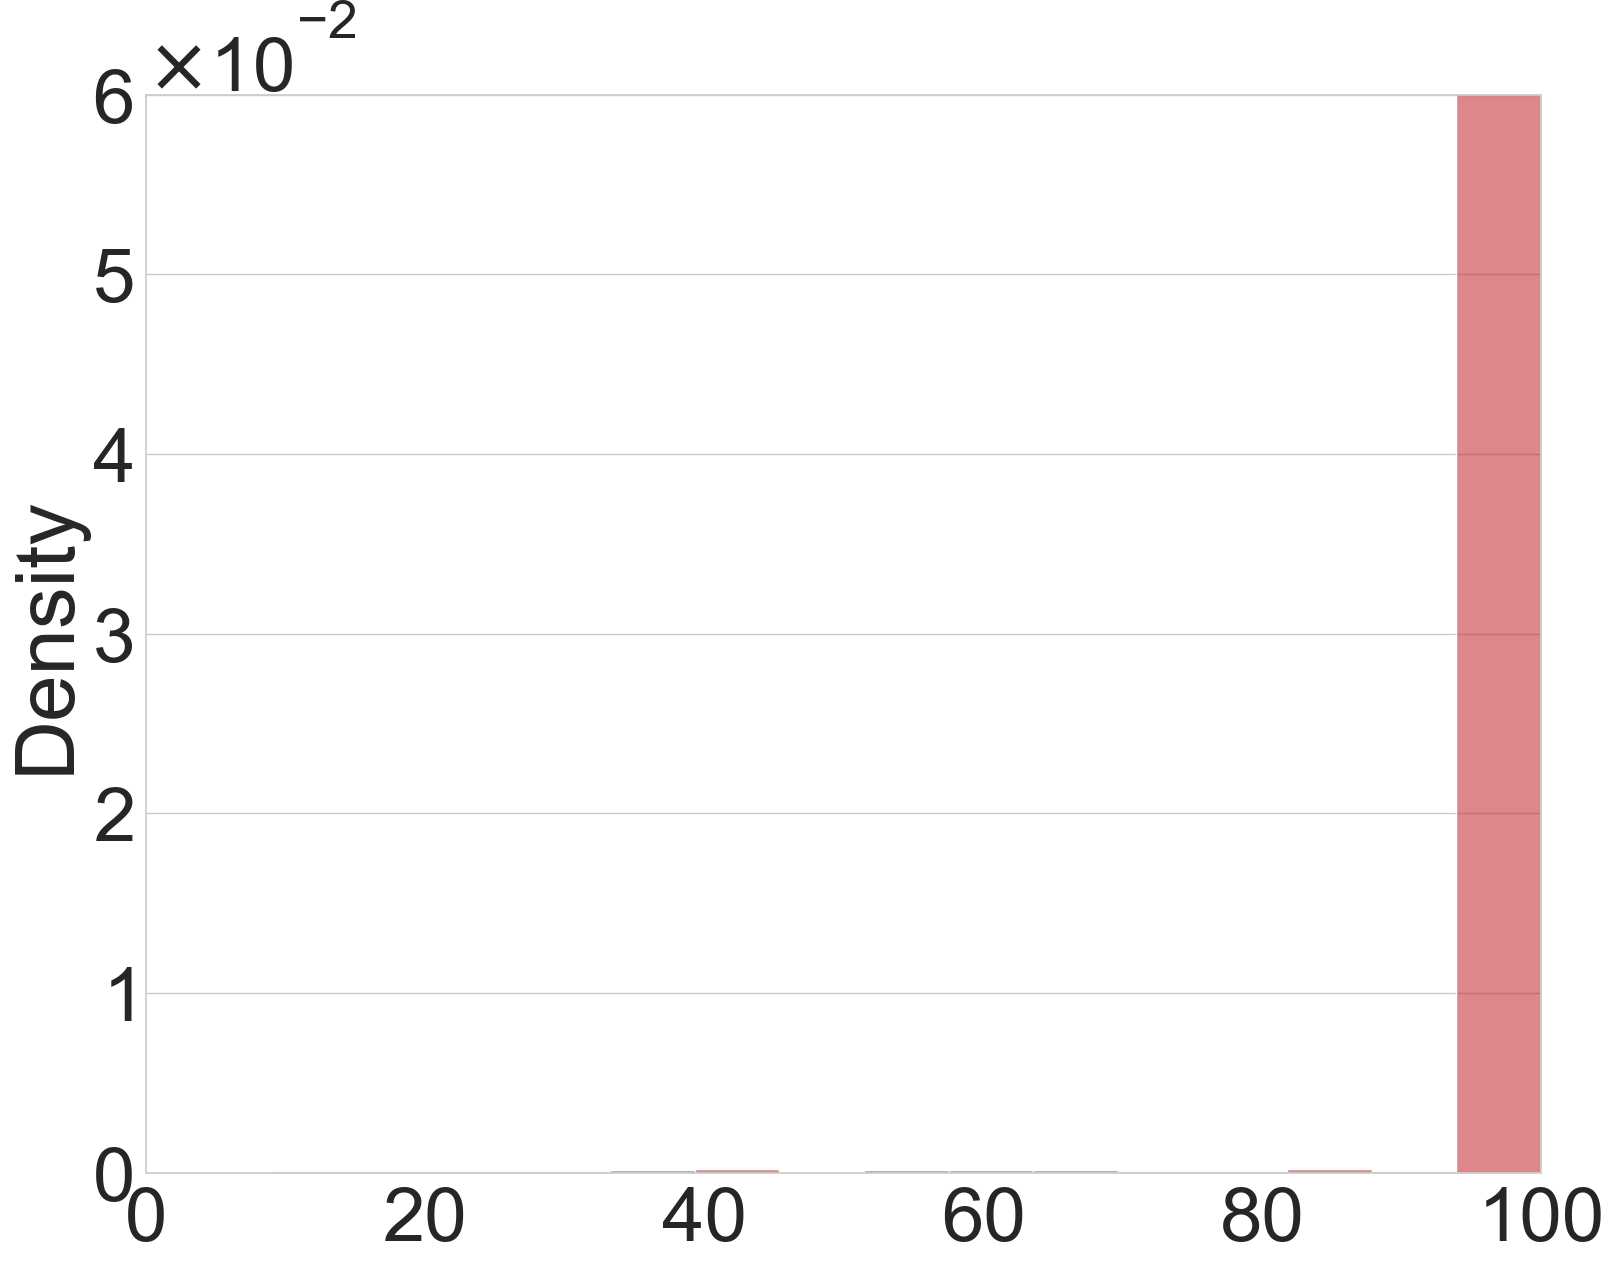

In [17]:
plot_histogram(
    df_articlepage.select(pl.col(DEFAULT_SCROLL_PERCENTAGE_COL).drop_nulls()),
    x_max=100,
    y_max=0.06,
    num_xticks=5,
    fontsize=60,
    column_name=DEFAULT_SCROLL_PERCENTAGE_COL,
    save_path=PLOT_PATH.joinpath(f"{DEFAULT_SCROLL_PERCENTAGE_COL}.png"),
)

## Article category distributions:

In [18]:
df_articles[DEFAULT_CATEGORY_STR_COL].value_counts(sort=True).head(15)

shape: (15, 2)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ category_str  ‚îÜ count ‚îÇ
‚îÇ ---           ‚îÜ ---   ‚îÇ
‚îÇ str           ‚îÜ u32   ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ nyheder       ‚îÜ 27876 ‚îÇ
‚îÇ underholdning ‚îÜ 24909 ‚îÇ
‚îÇ krimi         ‚îÜ 22579 ‚îÇ
‚îÇ sport         ‚îÜ 18767 ‚îÇ
‚îÇ side9         ‚îÜ 4628  ‚îÇ
‚îÇ ‚Ä¶             ‚îÜ ‚Ä¶     ‚îÇ
‚îÇ ferie         ‚îÜ 2396  ‚îÇ
‚îÇ biler         ‚îÜ 1964  ‚îÇ
‚îÇ play          ‚îÜ 1271  ‚îÇ
‚îÇ opinionen     ‚îÜ 580   ‚îÇ
‚îÇ vin           ‚îÜ 527   ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

In [43]:
translate = {
    "nyheder": "News",
    #
    "underholdning": "Entmt.",
    "musik": "Entmt.",
    #
    "krimi": "Crime",
    #
    "sport": "Sports",
    #
    "forbrug": "Lifestyle",
    "biler": "Lifestyle",
    "ferie": "Lifestyle",
    "vin": "Lifestyle",
    #
    "sex_og_samliv": "S&R",
    #
    "nationen": "Opinion",
    "opinionen": "Opinion",
}

df_category = (
    df_articles[DEFAULT_CATEGORY_STR_COL]
    .replace(translate, default="Misc.")
    .value_counts(sort=True)
    .with_columns(pl.col("count") / pl.col("count").sum())
)

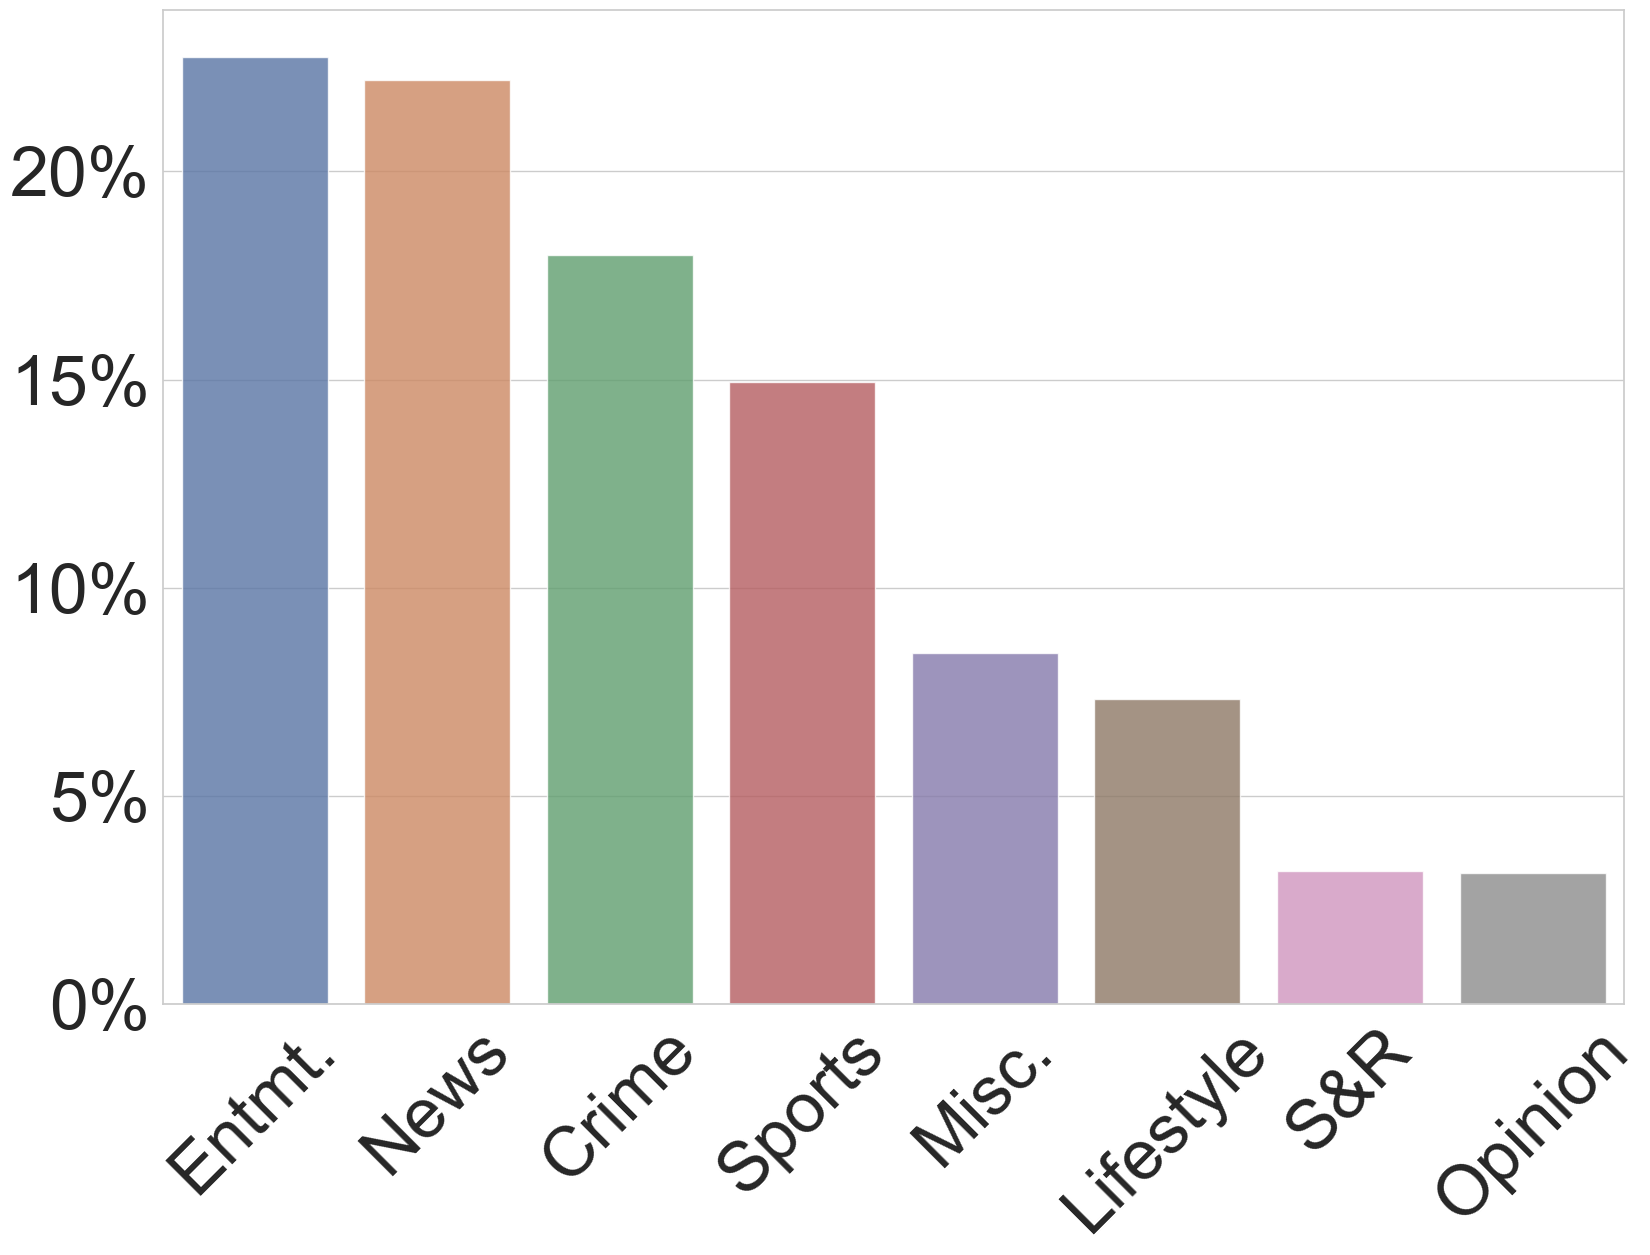

In [20]:
create_bar_plot(
    df_category.to_pandas(),
    x_col=DEFAULT_CATEGORY_STR_COL,
    y_col="count",
    y_as_percentage=True,
    colors=sns.color_palette(n_colors=df_category.shape[0]),
    fontsize=55,
    rotation=45,
    save_path=PLOT_PATH.joinpath(CATEGORY_DIST_NAME + ".png"),
)

-----
# Survival time:
We define "survival-time" as the interval between its publish time and last appearance time in behavioral dataset.

In [41]:
df_articles_in_period = df_articles.select(
    pl.col(DEFAULT_ARTICLE_ID_COL, DEFAULT_ARTICLE_PUBLISHED_TIMESTAMP_COL)
)

TIME_COLUMN = "survival_time"

df_survival_time = (
    df_behaviors.select(DEFAULT_ARTICLE_ID_COL, DEFAULT_IMPRESSION_TIMESTAMP_COL)
    .group_by(DEFAULT_ARTICLE_ID_COL)
    .agg(pl.col(DEFAULT_IMPRESSION_TIMESTAMP_COL).max())
    .collect()
    .join(
        df_articles.select(
            DEFAULT_ARTICLE_ID_COL, DEFAULT_ARTICLE_PUBLISHED_TIMESTAMP_COL
        ),
        on=DEFAULT_ARTICLE_ID_COL,
        how="inner",
    )
    .with_columns(
        (
            pl.col(DEFAULT_IMPRESSION_TIMESTAMP_COL)
            - pl.col(DEFAULT_ARTICLE_PUBLISHED_TIMESTAMP_COL)
        ).alias(TIME_COLUMN)
    )
)
df_survival_time.head(2)

shape: (2, 4)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ article_id ‚îÜ impression_time     ‚îÜ published_time      ‚îÜ survival_time    ‚îÇ
‚îÇ ---        ‚îÜ ---                 ‚îÜ ---                 ‚îÜ ---              ‚îÇ
‚îÇ i32        ‚îÜ datetime[Œºs]        ‚îÜ datetime[Œºs]        ‚îÜ duration[Œºs]     ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ 3971783    ‚îÜ 2023-05-31 21:29:29 ‚îÜ 2013-04-17 17:27:57 ‚îÜ 3696d 4h 1m 32s  ‚îÇ
‚îÇ 5563498    ‚îÜ 2023-05-23 21:08:33 ‚îÜ 2015-05-15 06:56:28 ‚îÜ 2930d 14h 12m 5s ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

### Convert to survival-time to hours:

In [42]:
ONE_HOUR = 60 * 60
SURVIVAL_TIME_ROUND = TIME_COLUMN + "_hours"
df_survival_time = df_survival_time.with_columns(
    pl.col(TIME_COLUMN)
    .map_elements(lambda x: x.total_seconds() // ONE_HOUR)
    .alias(SURVIVAL_TIME_ROUND)
)
print(df_survival_time.select(SURVIVAL_TIME_ROUND).describe())
df_survival_time.head(2)

shape: (9, 2)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ statistic  ‚îÜ survival_time_hours ‚îÇ
‚îÇ ---        ‚îÜ ---                 ‚îÇ
‚îÇ str        ‚îÜ f64                 ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ count      ‚îÜ 1731.0              ‚îÇ
‚îÇ null_count ‚îÜ 0.0                 ‚îÇ
‚îÇ mean       ‚îÜ 593.92721           ‚îÇ
‚îÇ std        ‚îÜ 4004.991975         ‚îÇ
‚îÇ min        ‚îÜ 0.0                 ‚îÇ
‚îÇ 25%        ‚îÜ 2.0                 ‚îÇ
‚îÇ 50%        ‚îÜ 5.0                 ‚îÇ
‚îÇ 75%        ‚îÜ 34.0                ‚îÇ
‚îÇ max        ‚îÜ 88708.0             ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò


shape: (2, 5)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ article_id ‚îÜ impression_time     ‚îÜ published_time      ‚îÜ survival_time    ‚îÜ survival_time_hours ‚îÇ
‚îÇ ---        ‚îÜ ---                 ‚îÜ ---                 ‚îÜ ---              ‚îÜ ---                 ‚îÇ
‚îÇ i32        ‚îÜ datetime[Œºs]        ‚îÜ datetime[Œºs]        ‚îÜ duration[Œºs]     ‚îÜ f64                 ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ 3971783    ‚îÜ 2023-05-31 21:29:29 ‚îÜ 2013-04-17 17:27:57 ‚îÜ 3696d 4h 1m 32s  ‚îÜ 88708.0             ‚îÇ
‚îÇ 5563498    ‚îÜ 2023-05-23 21:08:33 ‚îÜ 2015-05-15 06:56:28 ‚îÜ 2930d 14h 12m 5s ‚îÜ 70334.0             ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

### Plot survival time

In [23]:
N_HOURS = 24
frac_impresion_covered = (
    df_survival_time.filter(pl.col(SURVIVAL_TIME_ROUND) < N_HOURS).shape[0]
    / df_survival_time.shape[0]
)
print(f"Fraction of impressions covered: {round(frac_impresion_covered,3)*100}%")

Fraction of impressions covered: 72.8%


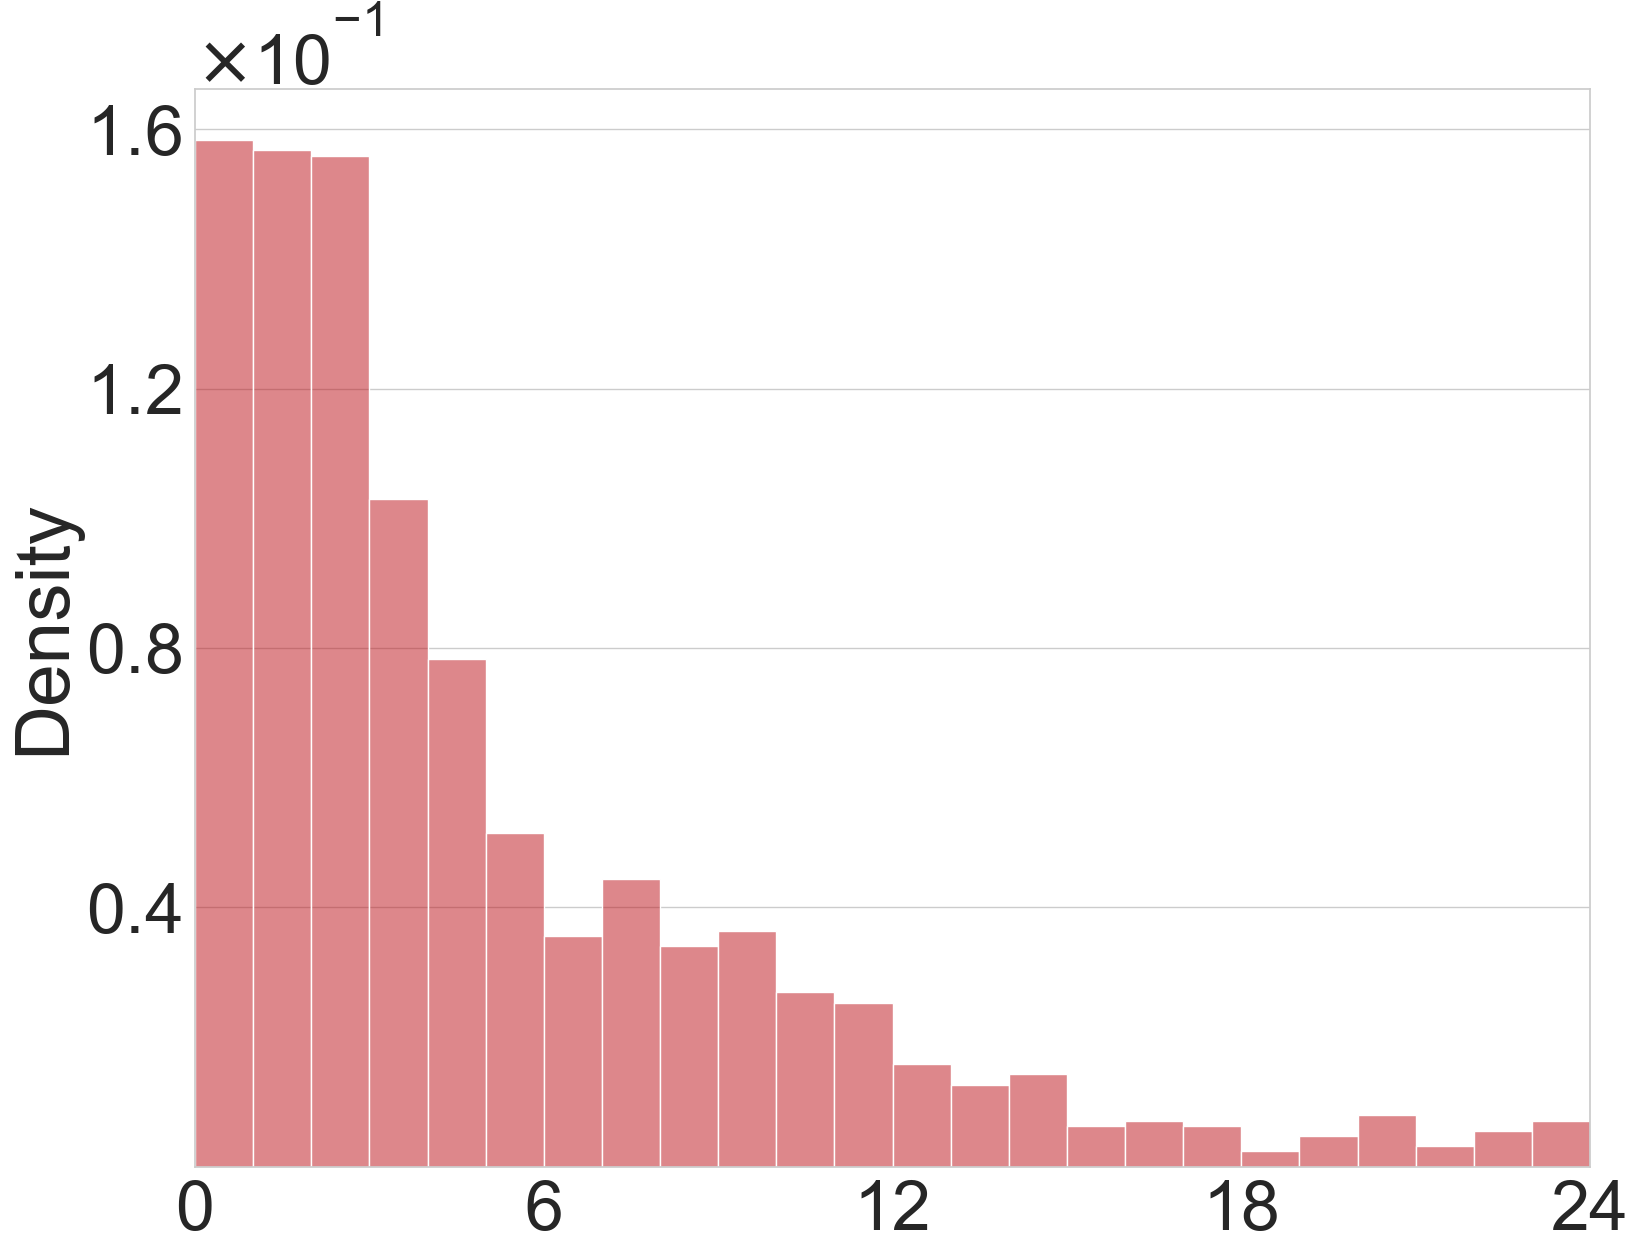

In [24]:
plot_histogram(
    df=df_survival_time.filter(pl.col(SURVIVAL_TIME_ROUND) <= N_HOURS).select(
        SURVIVAL_TIME_ROUND
    ),
    column_name=SURVIVAL_TIME_ROUND,
    x_max=N_HOURS,
    bins=N_HOURS,
    fontsize=60,
    num_xticks=N_HOURS // 6,
    num_yticks=5,
    save_path=PLOT_PATH.joinpath(SURVIVAL_TIME_ROUND + f".png"),
)

In [25]:
CUM_SUM_FRAC = "cum_sum_frac"
df_agg_survival_time = (
    df_survival_time[SURVIVAL_TIME_ROUND]
    .value_counts(sort=True)
    .with_columns(pl.col("count").cum_sum().alias(CUM_SUM_FRAC) / pl.col("count").sum())
)
df_agg_survival_time.head(5)

shape: (5, 3)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ survival_time_hours ‚îÜ count ‚îÜ cum_sum_frac ‚îÇ
‚îÇ ---                 ‚îÜ ---   ‚îÜ ---          ‚îÇ
‚îÇ f64                 ‚îÜ u32   ‚îÜ f64          ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ 0.0                 ‚îÜ 200   ‚îÜ 0.11554      ‚îÇ
‚îÇ 1.0                 ‚îÜ 198   ‚îÜ 0.229925     ‚îÇ
‚îÇ 2.0                 ‚îÜ 197   ‚îÜ 0.343732     ‚îÇ
‚îÇ 3.0                 ‚îÜ 130   ‚îÜ 0.418833     ‚îÇ
‚îÇ 4.0                 ‚îÜ 99    ‚îÜ 0.476025     ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

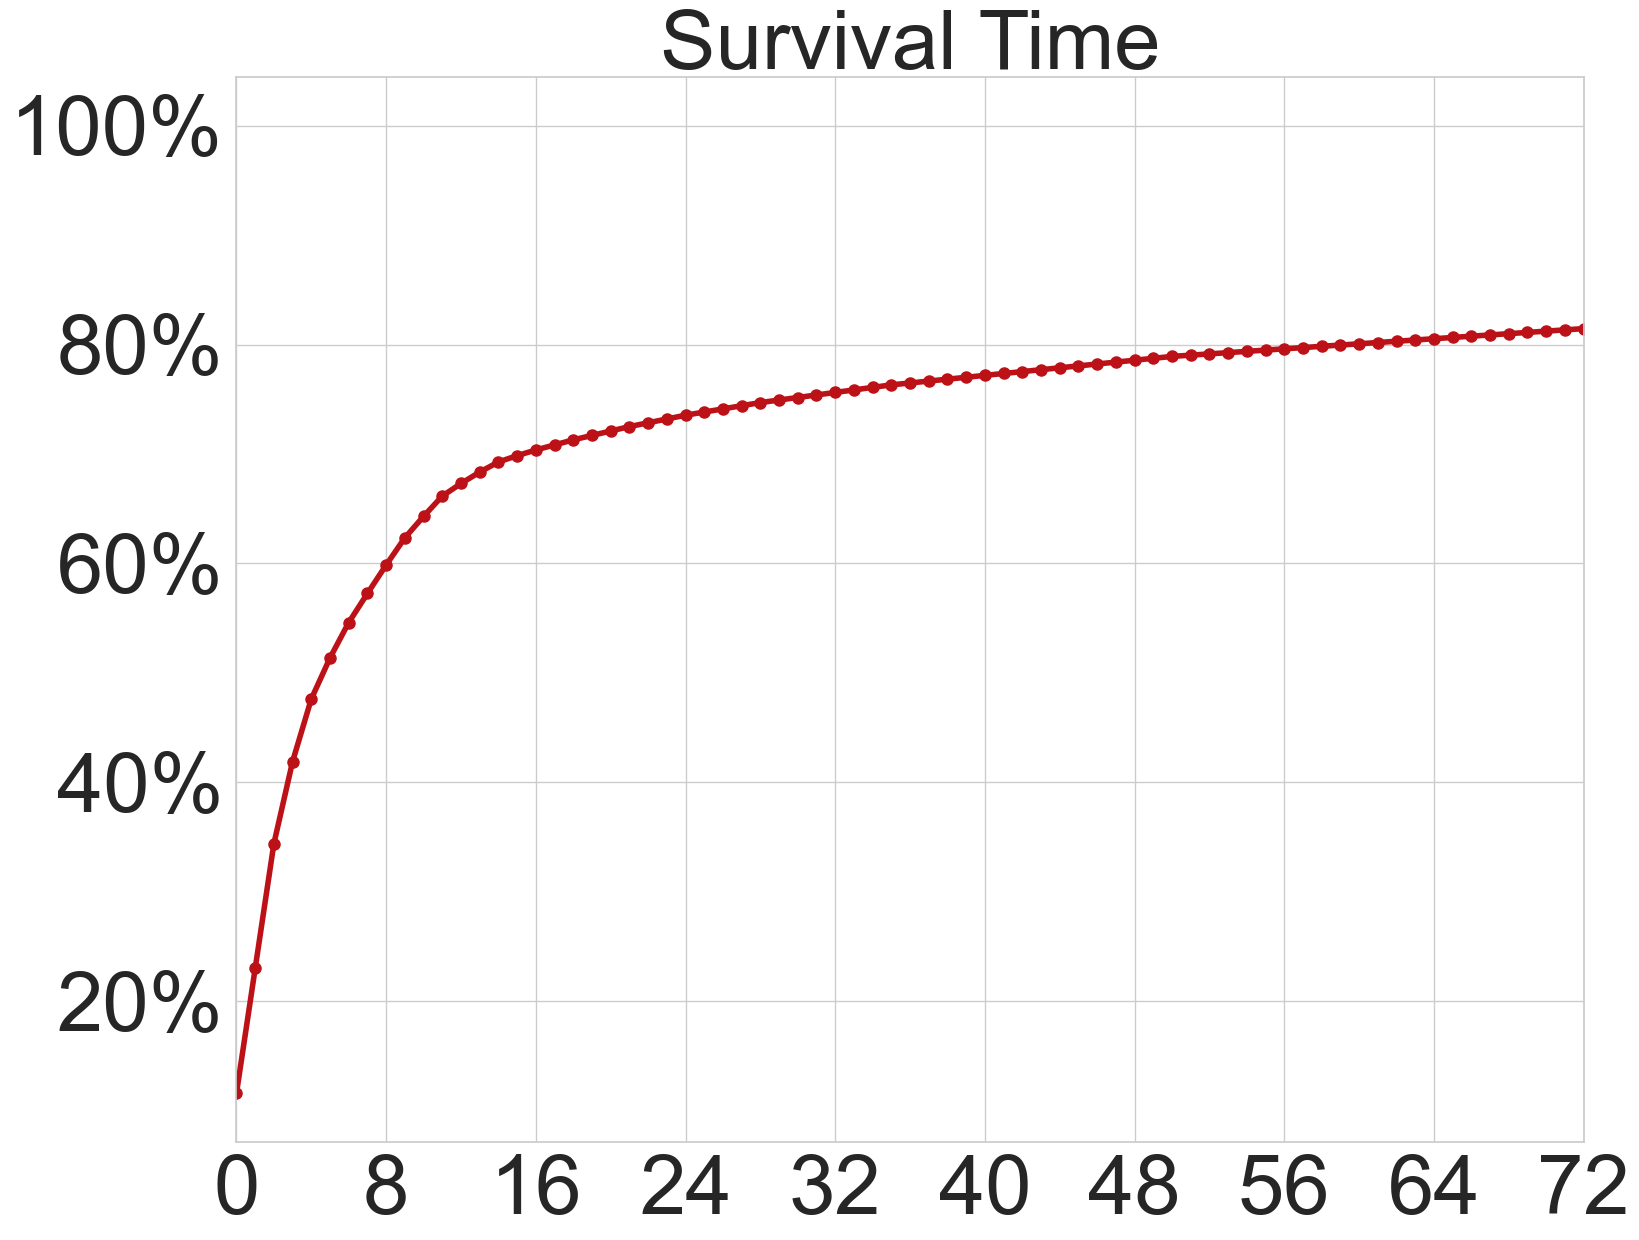

In [26]:
X_HOURS = 72
create_plot(
    df_agg_survival_time[CUM_SUM_FRAC],
    fontsize=60,
    marker="o",
    y_as_percentage=True,
    num_xticks=10,
    x_max=X_HOURS,
    color=EB_COLOR,
    linewidth=4,
    markersize=8,
    linestyle="-",
    title="Survival Time",
    save_path=PLOT_PATH.joinpath(f"survival_time_{X_HOURS}.png"),
)

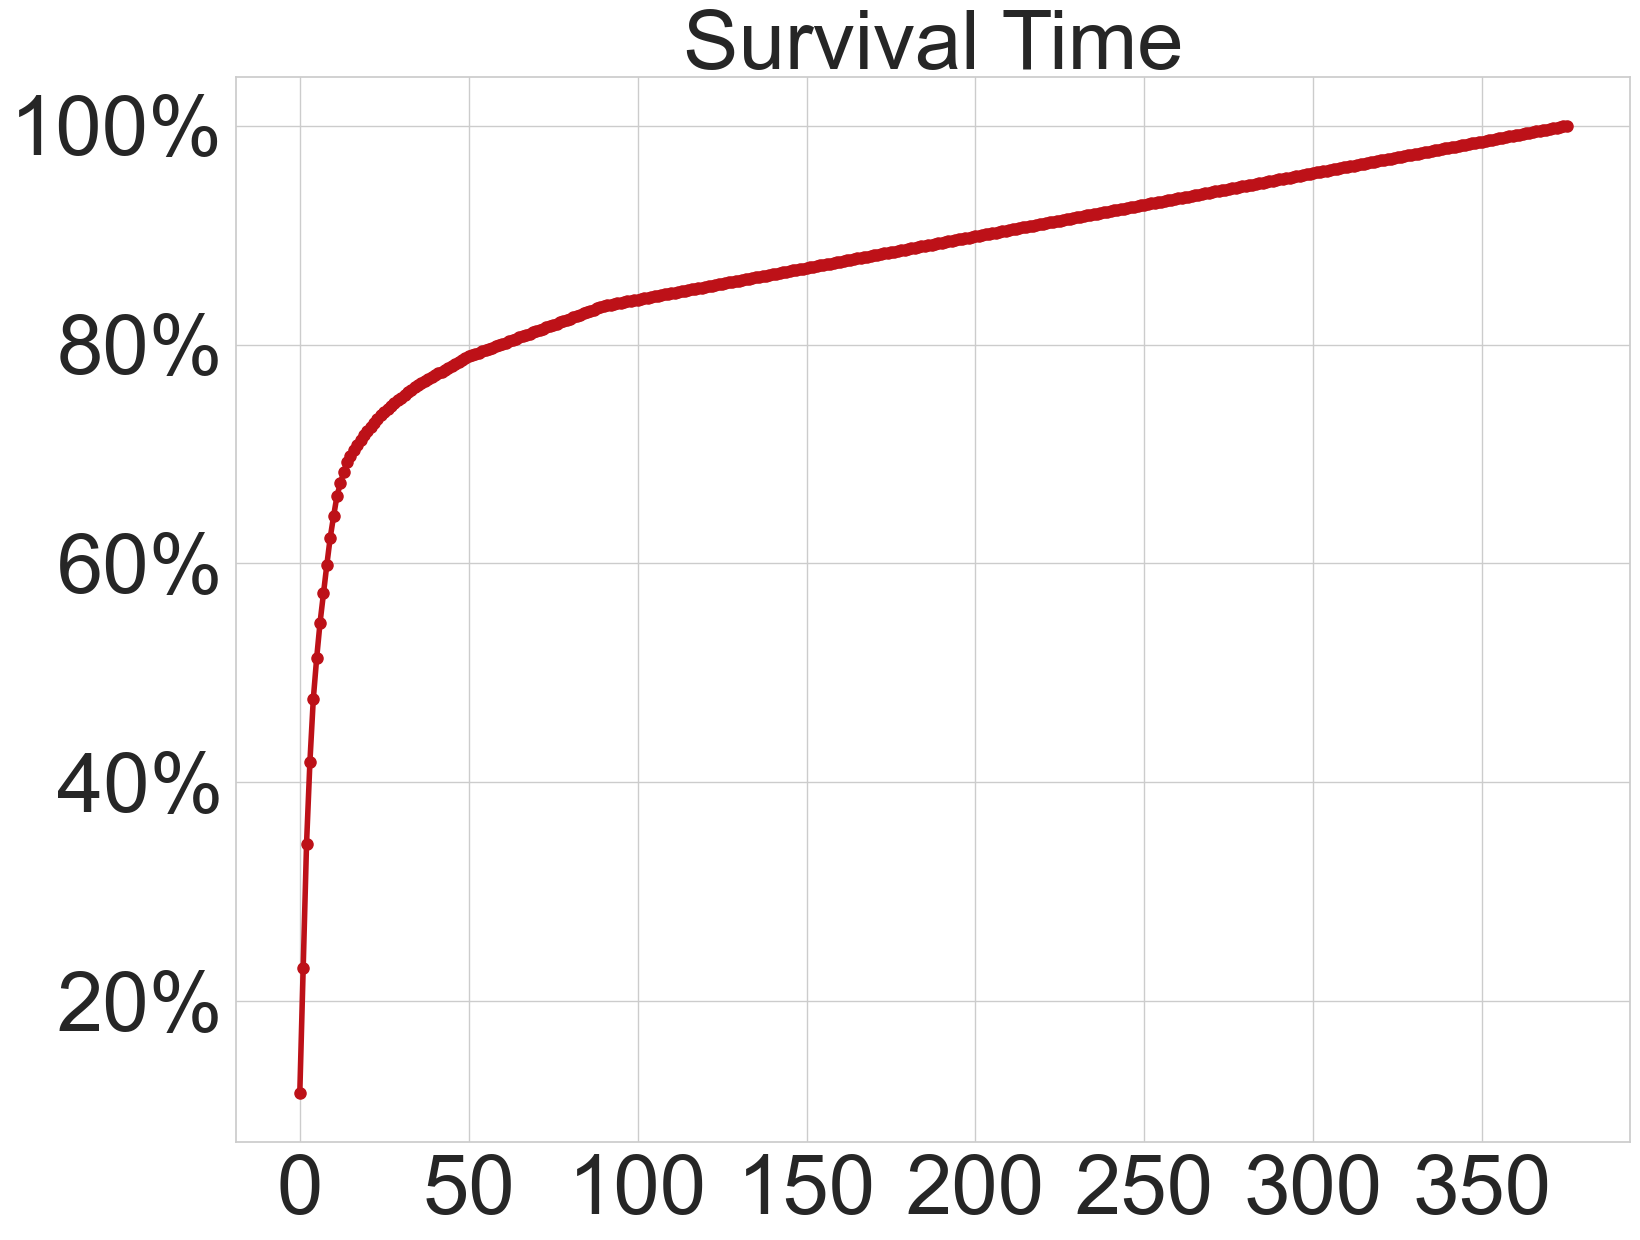

In [27]:
create_plot(
    df_agg_survival_time[CUM_SUM_FRAC],
    fontsize=60,
    marker="o",
    y_as_percentage=True,
    num_xticks=10,
    color=EB_COLOR,
    linewidth=4,
    markersize=8,
    linestyle="-",
    title="Survival Time",
    save_path=PLOT_PATH.joinpath(f"survival_time_full.png"),
)

# DONE üöÄ